In [2]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import torch.optim as optim

In [23]:
# Estimate B_j
# just cyclic group

Y = 15
G = 15

B1 = torch.zeros(G, Y)
B2 = torch.zeros(Y, Y)

# weight_g = torch.randn(G)
weight_y = torch.rand(G)
weight_g = torch.rand(Y)

for g in range(G):
    input_g = torch.zeros(G)
    input_g[g] = 1

    for y in range(Y):
        # 
        n = (g + y) % Y
        input_y = torch.zeros(Y)
        input_y[y] = 1
        
        output_n = torch.zeros(Y)
        output_n[n] = 1
        
        output_n = output_n - output_n.mean()
        
        B1 = B1 + torch.outer(input_g, output_n) * (weight_g[g] * weight_y[y])
        B2 = B2 + torch.outer(input_y, output_n) * (weight_g[g] * weight_y[y])
        
B1 = B1 / G / Y
B2 = B2 / G / Y

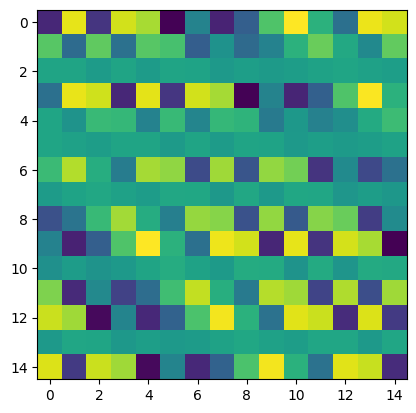

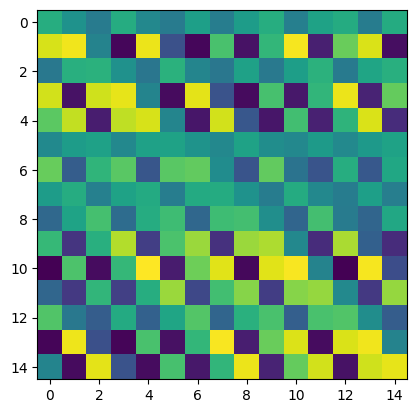

In [24]:
plt.figure()
plt.imshow(B1)

plt.figure()
plt.imshow(B2)


In [20]:
B1

tensor([[ 6.6227e-11,  6.6227e-11,  5.9605e-10,  5.9605e-10,  3.3114e-10,
          3.3114e-10,  3.3114e-10,  3.3114e-10,  3.3114e-10,  4.6359e-10,
          5.9605e-10,  4.6359e-10,  3.3114e-10,  1.6557e-10,  0.0000e+00],
        [-2.6491e-10, -3.9736e-10, -3.9736e-10, -3.9736e-10, -2.6491e-10,
         -2.6491e-10, -2.6491e-10, -2.6491e-10, -2.6491e-10, -2.6491e-10,
         -2.6491e-10, -2.6491e-10, -2.9802e-10, -3.3114e-10, -2.3180e-10],
        [-6.9539e-10, -5.2982e-10, -7.2850e-10, -7.2850e-10, -4.6359e-10,
         -4.6359e-10, -1.9868e-10, -1.9868e-10, -1.9868e-10,  6.6227e-11,
         -6.6227e-11, -1.9868e-10, -3.3114e-10, -4.6359e-10, -5.9605e-10],
        [-4.9671e-11, -5.7949e-11, -6.6227e-11, -1.1590e-10, -1.1590e-10,
         -1.1590e-10, -4.9671e-11, -1.1590e-10, -4.9671e-11, -1.1590e-10,
         -8.2784e-11, -4.9671e-11, -4.9671e-11, -4.9671e-11, -4.9671e-11],
        [ 8.6096e-10,  9.2718e-10,  9.9341e-10,  1.0596e-09,  1.0596e-09,
          1.0596e-09,  7.9473e-10,

In [97]:
# dynamics 
d = 10

x = torch.rand(d) 
x = x / x.norm()
alpha = 0.1

nIter = 1000
for t in range(nIter):
    dx = x**2 # * (1 - x)
    x = x + alpha * dx
    x = x / x.norm()
    
print(x)

tensor([3.2910e-39, 4.1560e-41, 1.7903e-41, 2.2219e-41, 9.2171e-40, 1.2355e-40,
        2.2108e-41, 3.1959e-41, 3.1573e-41, 1.0000e+00])


tensor([2.2075e-41, 9.1910e-41, 4.6613e-41, 1.0000e+00, 1.1295e-40, 5.4126e-40,
        8.1696e-43, 5.7619e-41, 1.9334e-41, 8.9753e-42])


In [53]:
x**2

tensor([9.6266e-24, 2.2689e-20, 1.5884e-24, 4.2864e-21, 3.3351e-01, 3.3296e-01,
        9.1417e-24, 3.1771e-12, 3.3352e-01, 1.2868e-18])

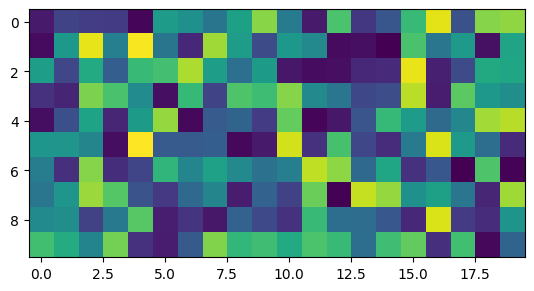

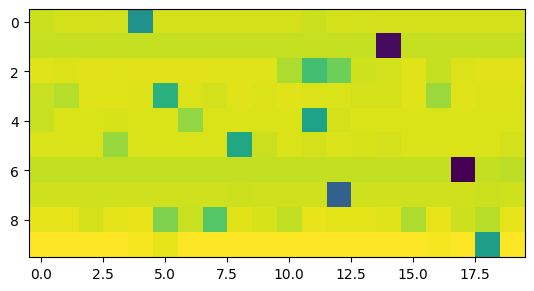

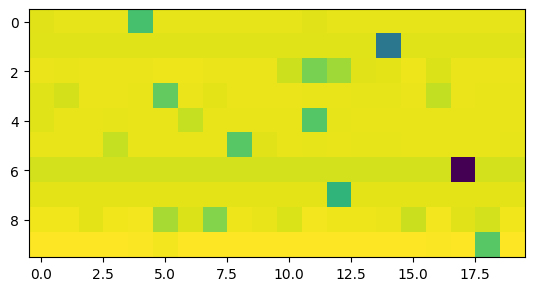

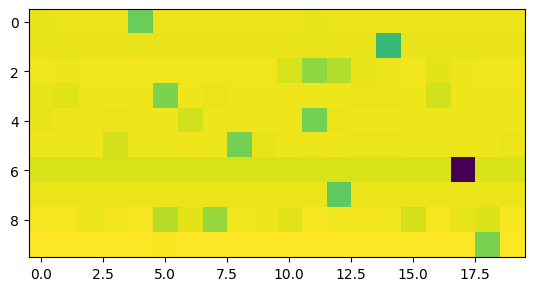

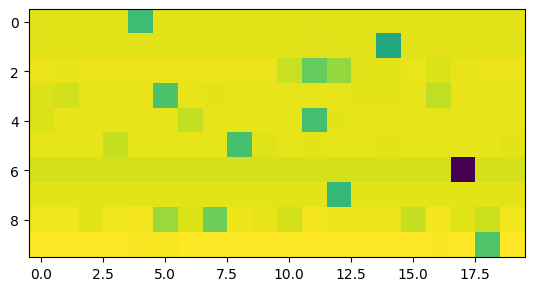

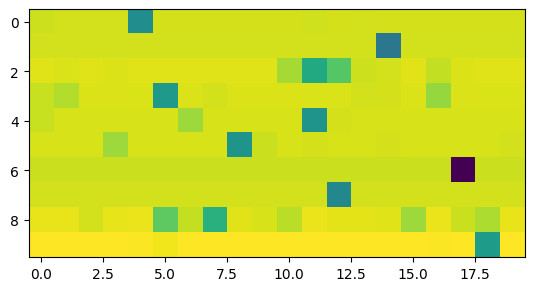

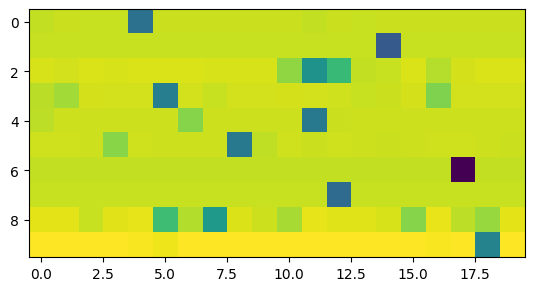

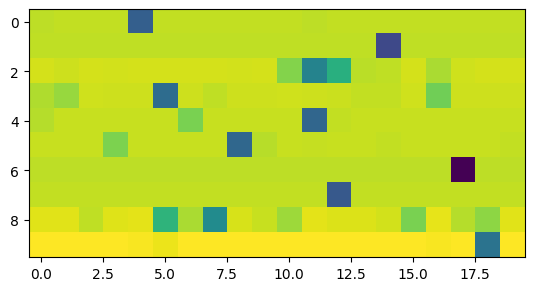

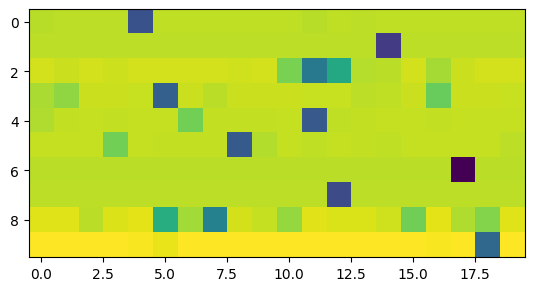

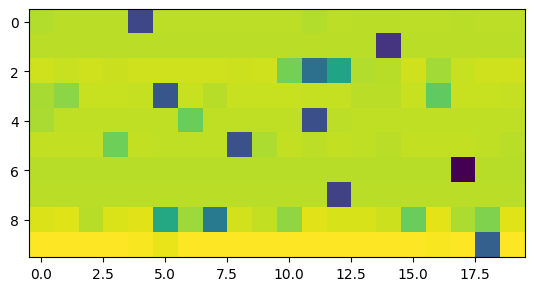

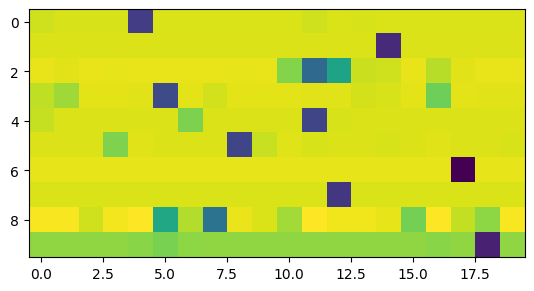

In [115]:
# dynamics 2
d = 10
N = 20

X = torch.rand(d, N)
# X = X / X.norm(dim=0, keepdim=True)

alpha = 0.1
nIter = 10000
for t in range(nIter):
    dX = X**1.5 * (N - X.sum(dim=1,keepdim=True))
    X = X + alpha * dX
    # X = X / X.norm(dim=0, keepdim=True)
    if t % 1000 == 0:
        plt.figure()
        plt.imshow(X)
    
plt.figure()
plt.imshow(X)

In [116]:
X

tensor([[1.0097, 1.0112, 1.0112, 1.0111, 0.9187, 1.0114, 1.0114, 1.0114, 1.0114,
         1.0114, 1.0114, 1.0098, 1.0114, 1.0111, 1.0113, 1.0114, 1.0114, 1.0113,
         1.0114, 1.0114],
        [1.0121, 1.0121, 1.0121, 1.0121, 1.0121, 1.0121, 1.0121, 1.0121, 1.0121,
         1.0121, 1.0121, 1.0121, 1.0121, 1.0121, 0.9118, 1.0121, 1.0121, 1.0121,
         1.0121, 1.0121],
        [1.0143, 1.0129, 1.0144, 1.0137, 1.0144, 1.0144, 1.0145, 1.0143, 1.0140,
         1.0143, 0.9959, 0.9384, 0.9675, 1.0085, 1.0097, 1.0145, 1.0052, 1.0131,
         1.0144, 1.0143],
        [1.0068, 1.0010, 1.0133, 1.0133, 1.0128, 0.9250, 1.0132, 1.0101, 1.0133,
         1.0132, 1.0134, 1.0128, 1.0125, 1.0104, 1.0108, 1.0134, 0.9918, 1.0133,
         1.0130, 1.0129],
        [1.0078, 1.0121, 1.0121, 1.0118, 1.0121, 1.0121, 0.9945, 1.0121, 1.0121,
         1.0120, 1.0121, 0.9220, 1.0112, 1.0121, 1.0121, 1.0121, 1.0121, 1.0121,
         1.0121, 1.0121],
        [1.0122, 1.0122, 1.0122, 0.9948, 1.0122, 1.0120, 1.0

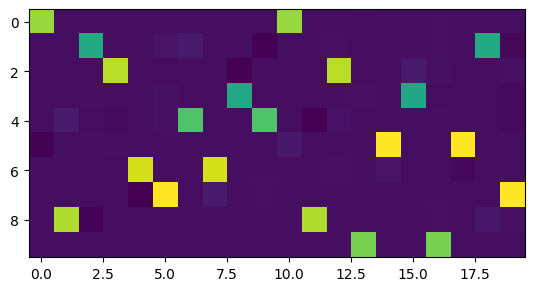

In [239]:
# check the dynamics
d = 10
K = 20
C = torch.rand(d, K) * 0.01

nIter = 1000
alpha = 0.6

allC = torch.randn(d, K, nIter)

for t in range(nIter):
    allC[:,:,t] = C
    dC = 2*C**2 - 2*C @ ((C.t() @ C) * (C.t() @ C))
    C = C + alpha * dC
  
plt.imshow(C)

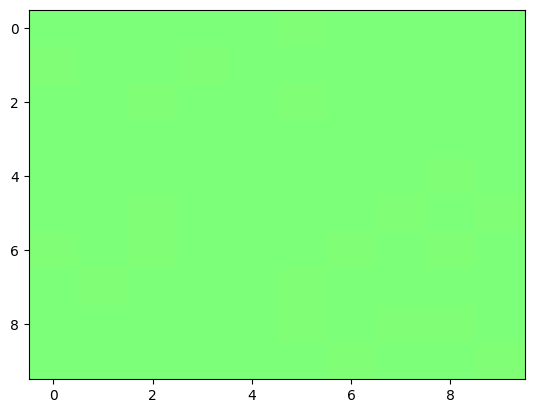

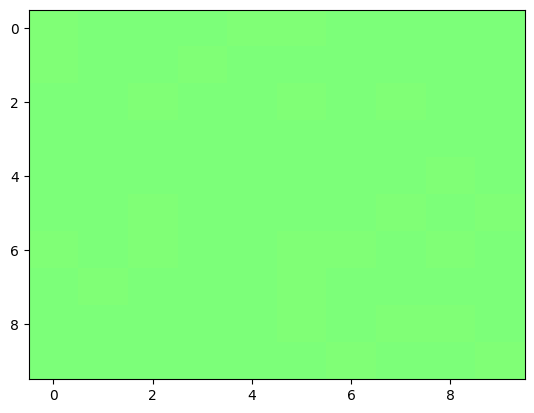

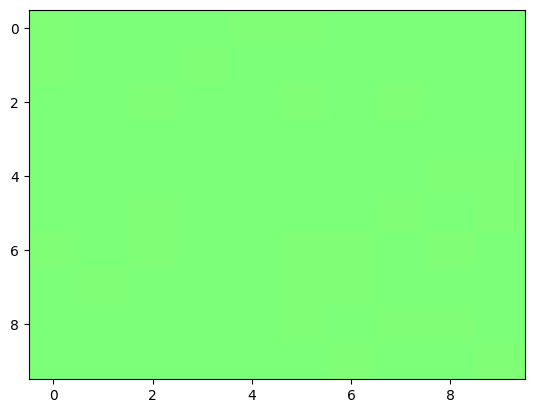

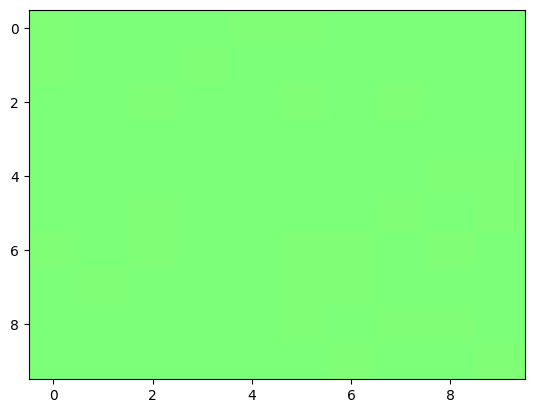

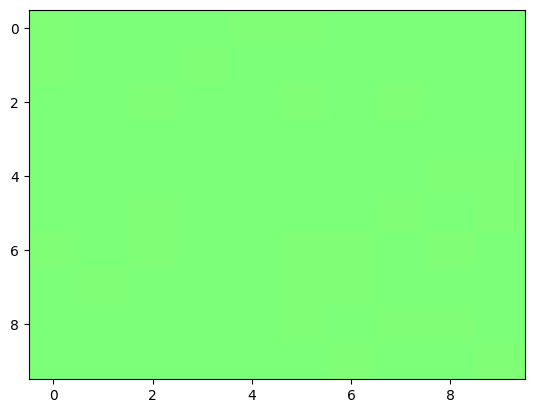

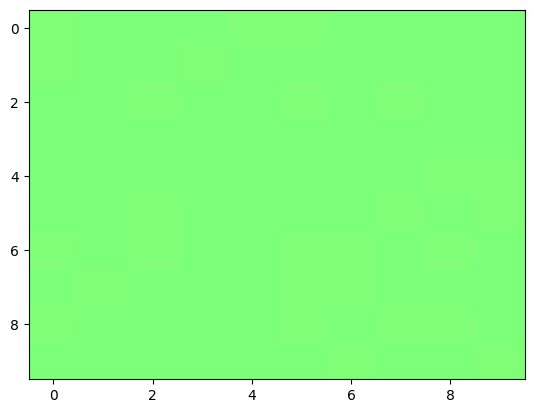

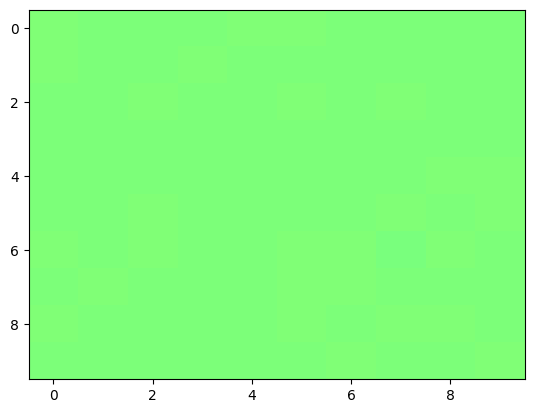

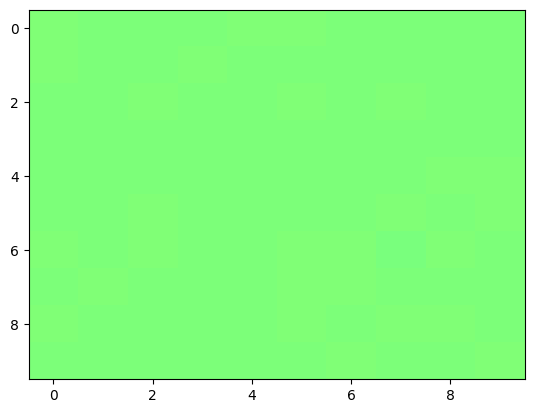

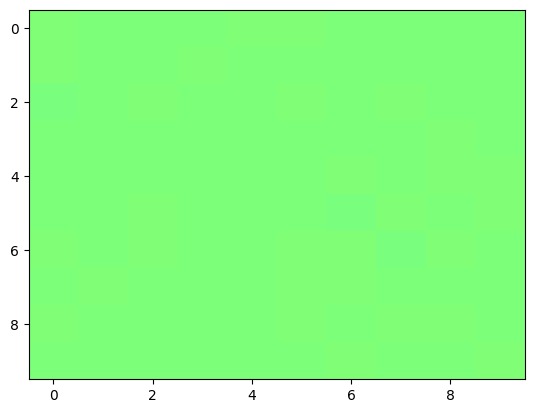

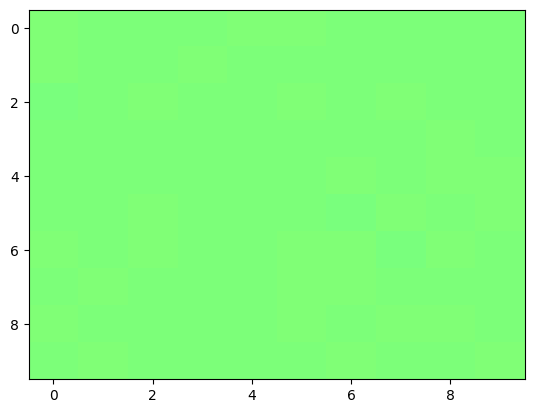

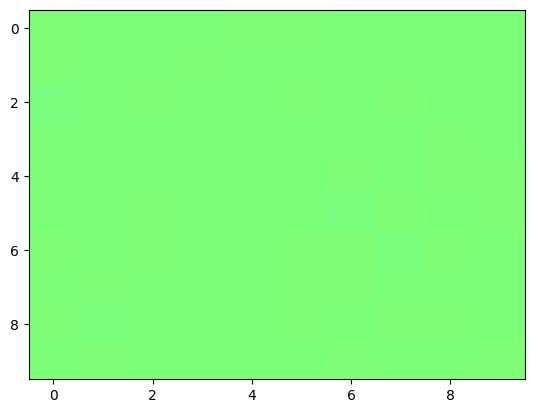

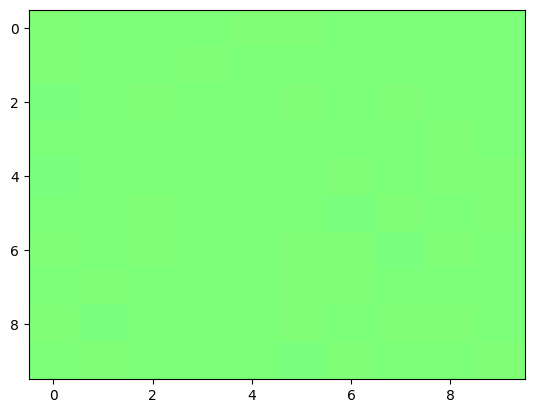

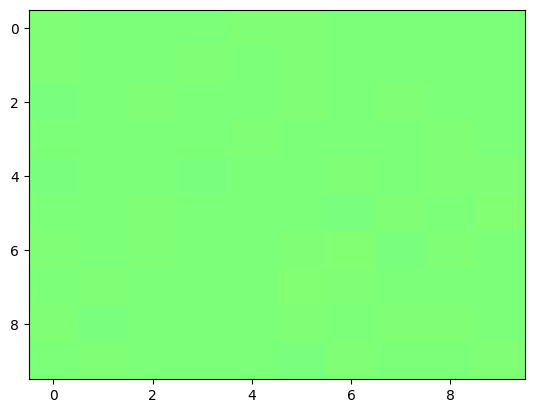

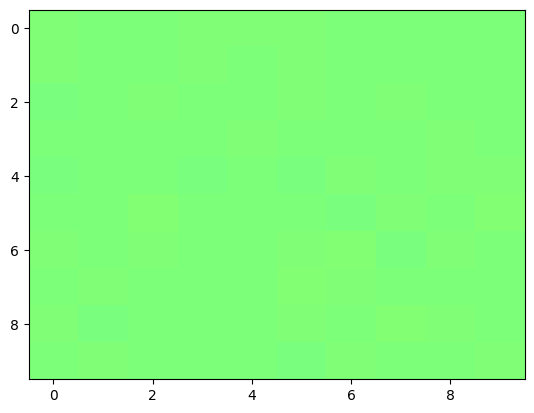

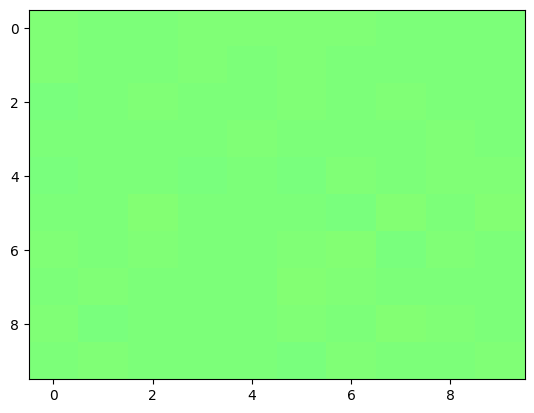

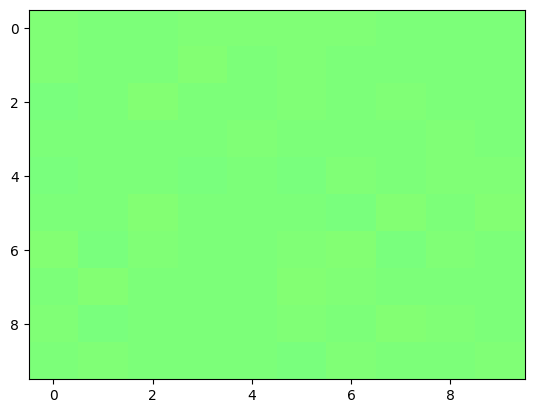

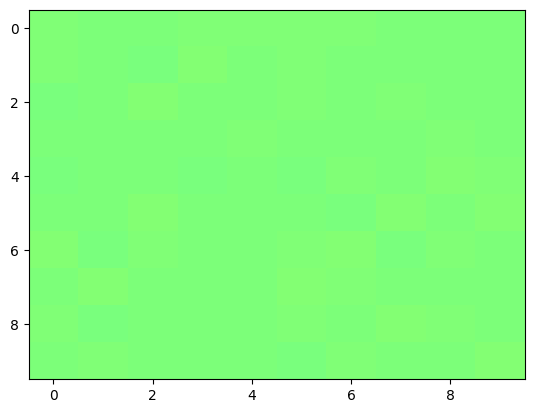

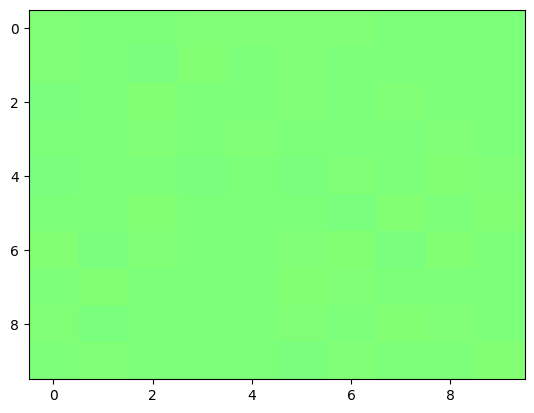

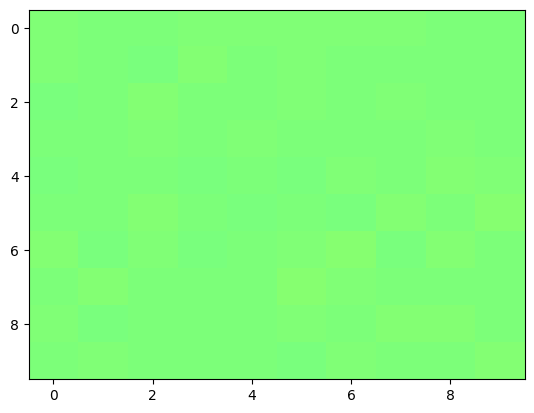

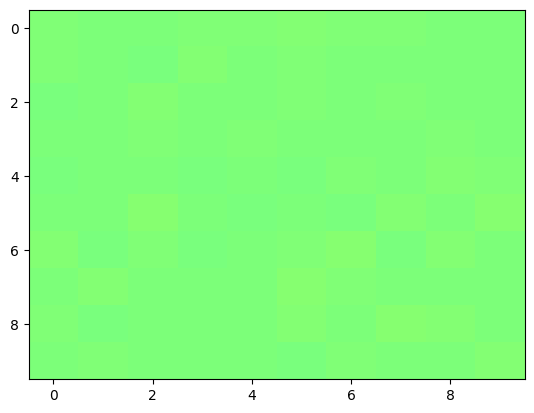

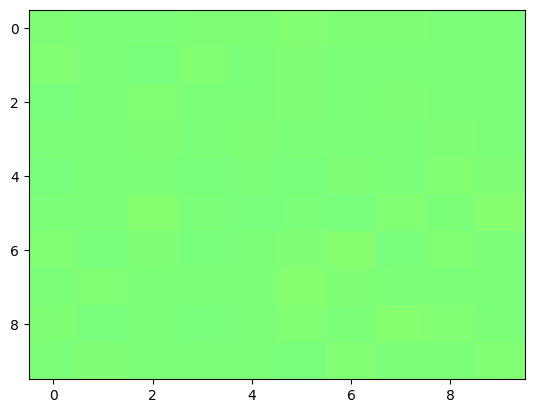

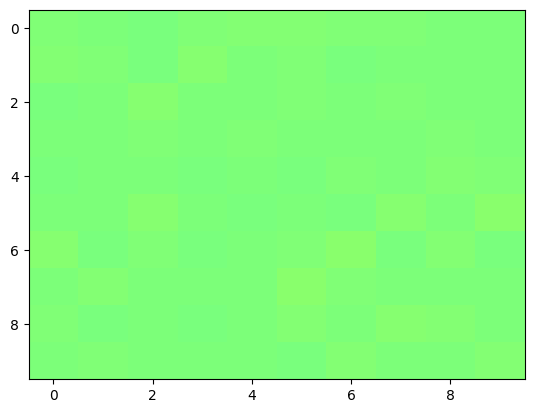

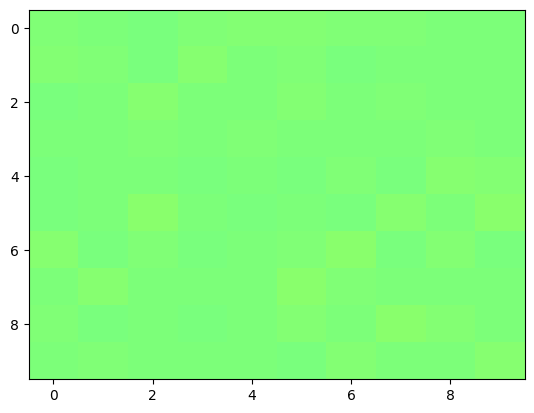

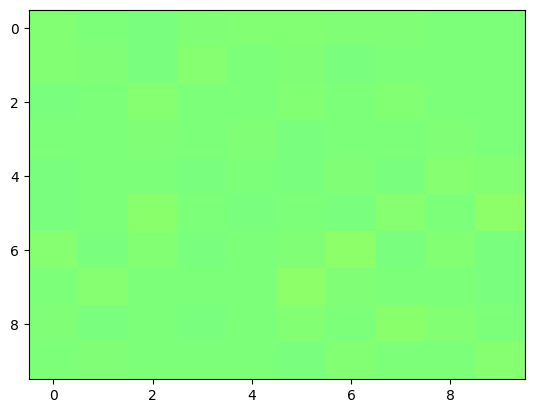

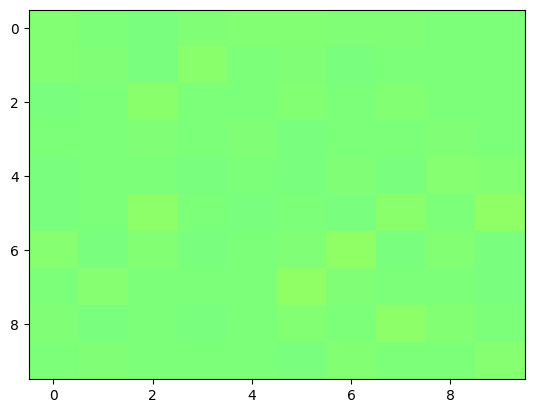

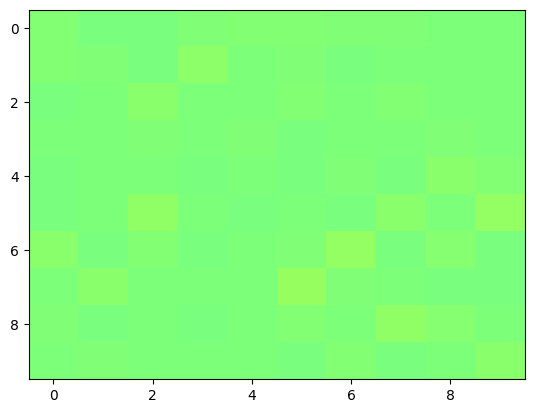

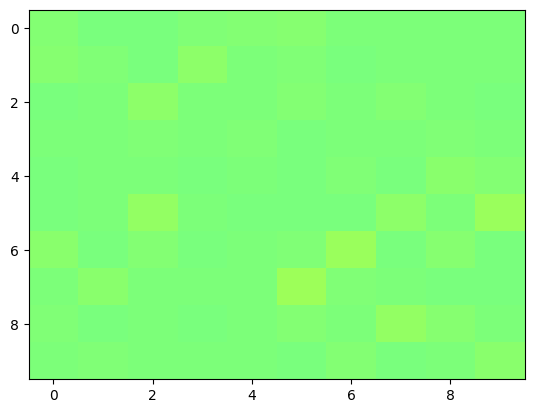

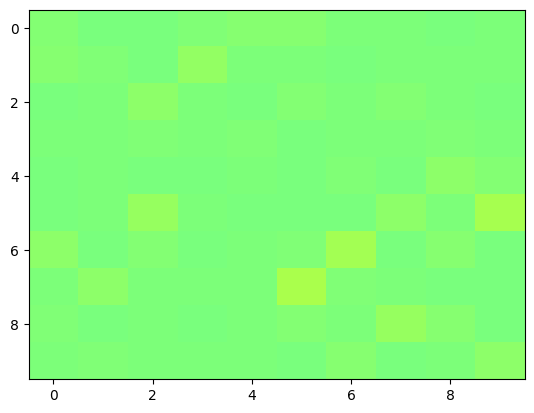

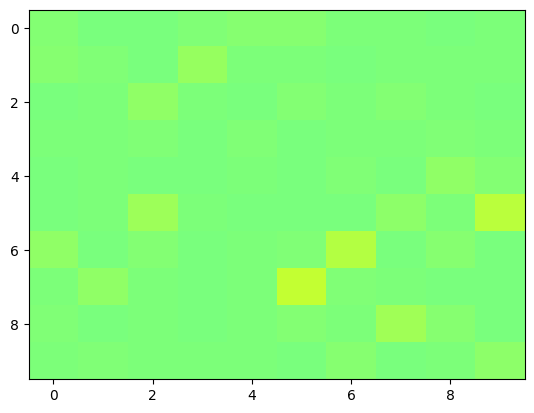

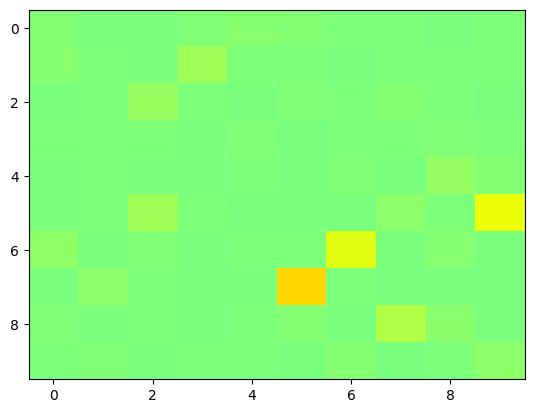

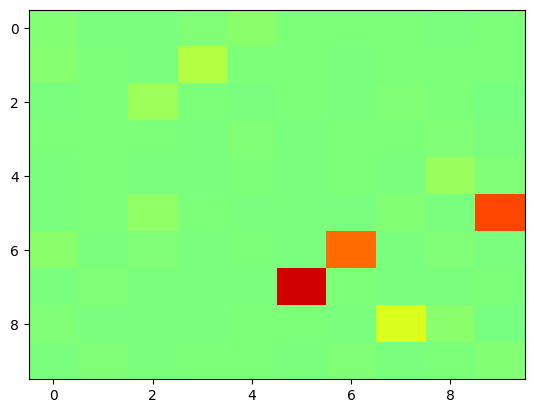

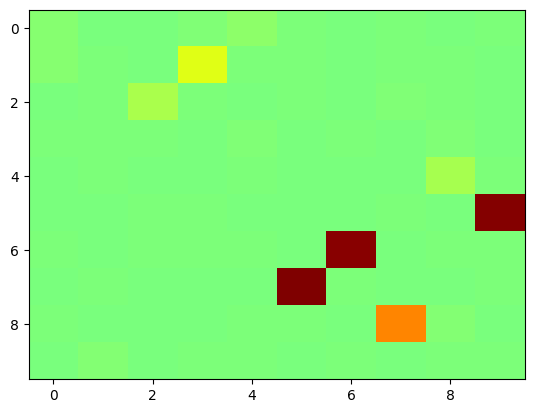

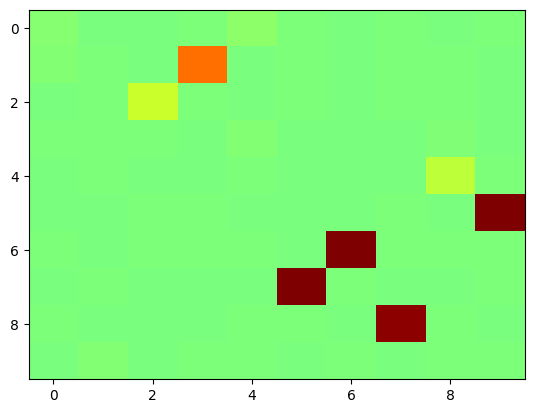

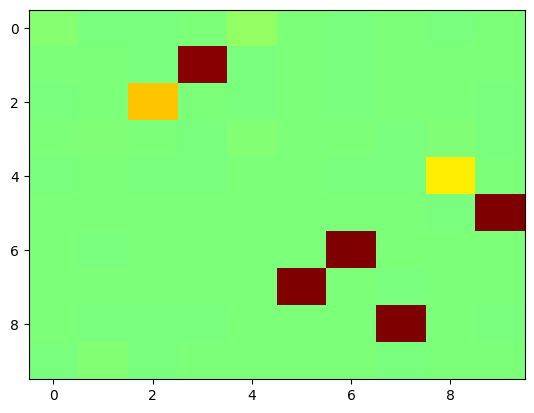

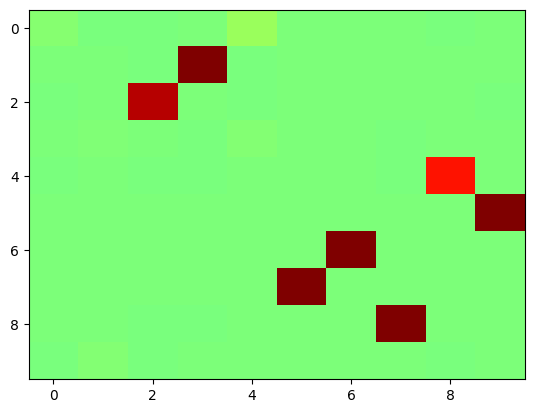

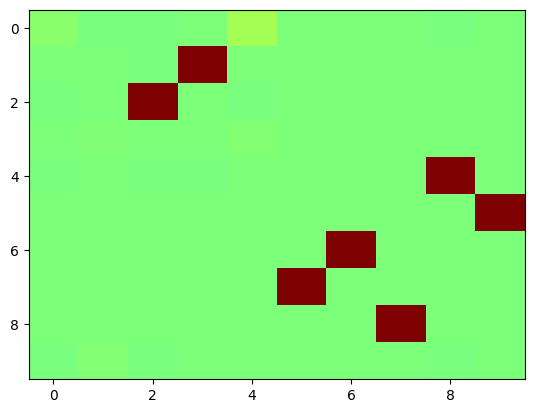

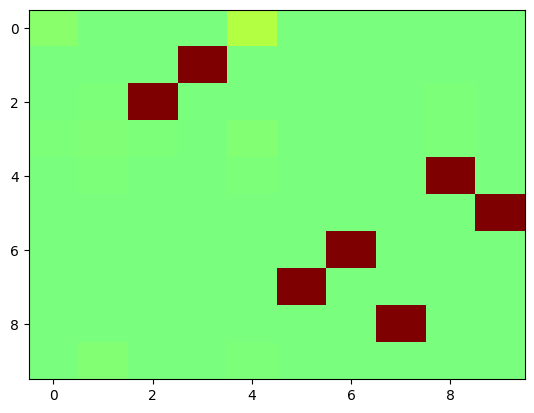

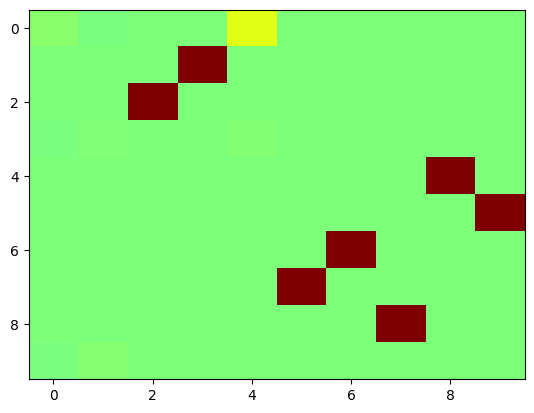

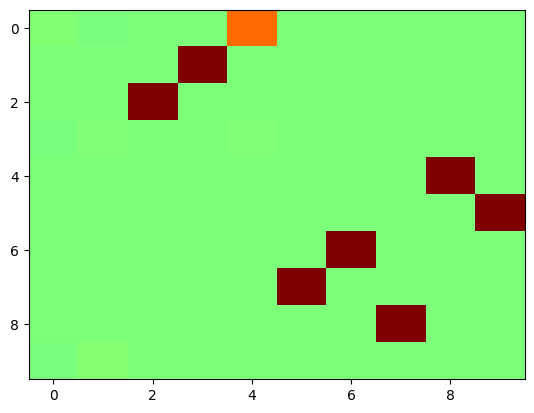

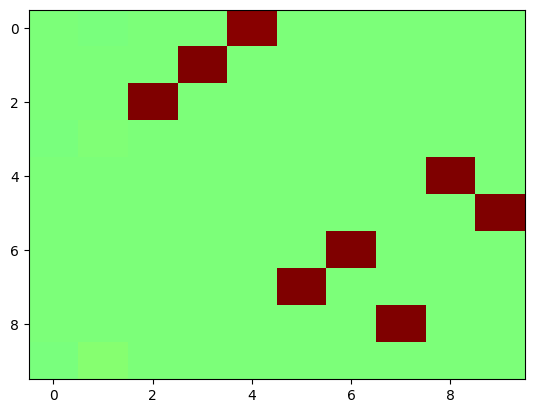

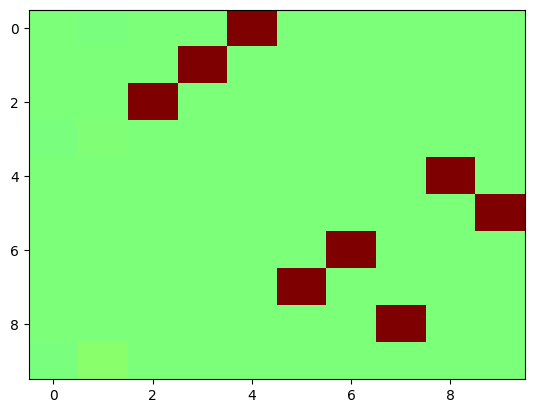

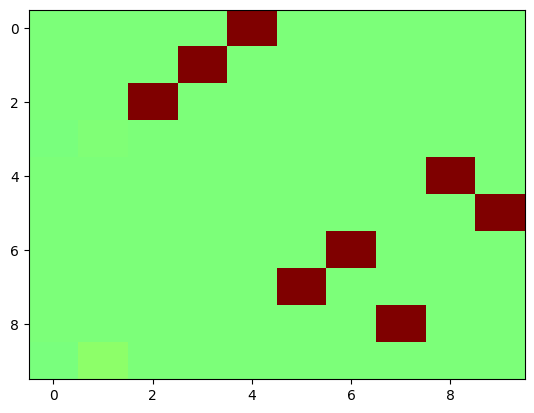

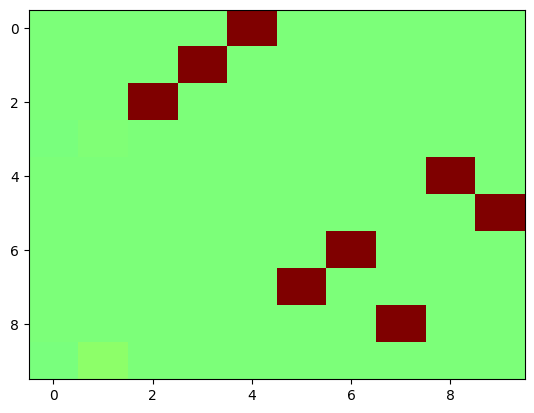

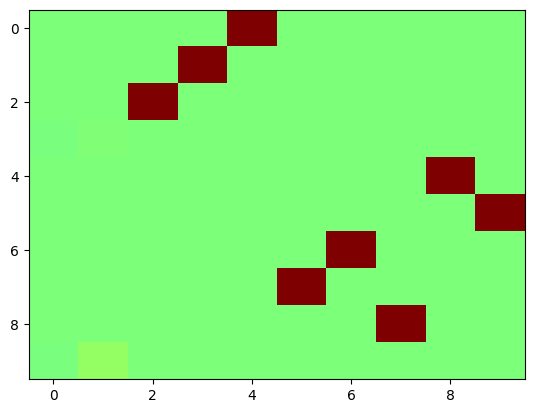

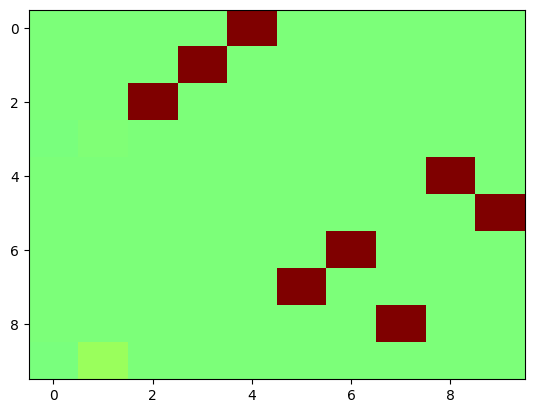

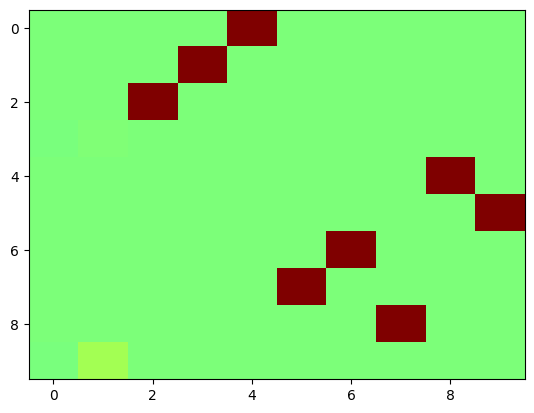

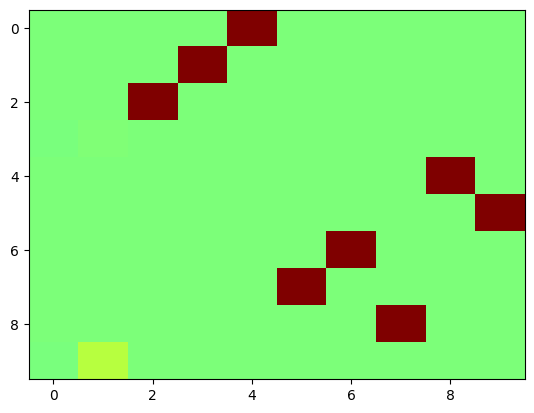

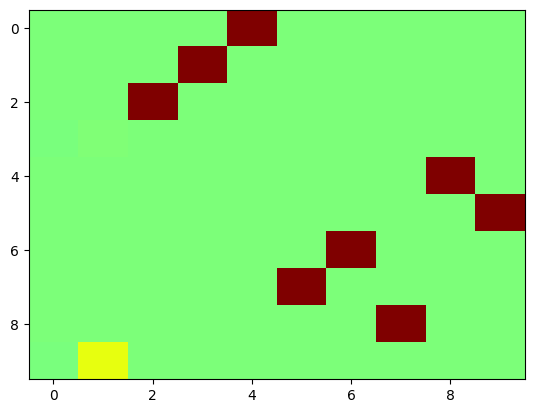

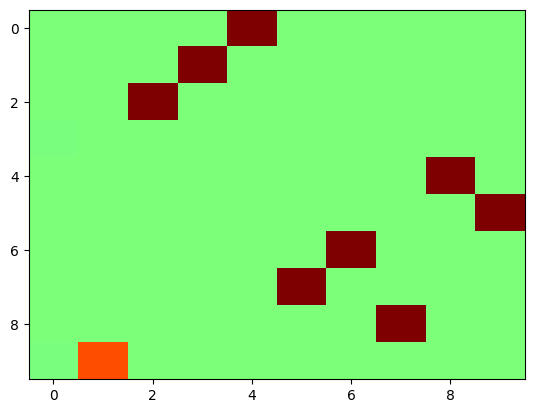

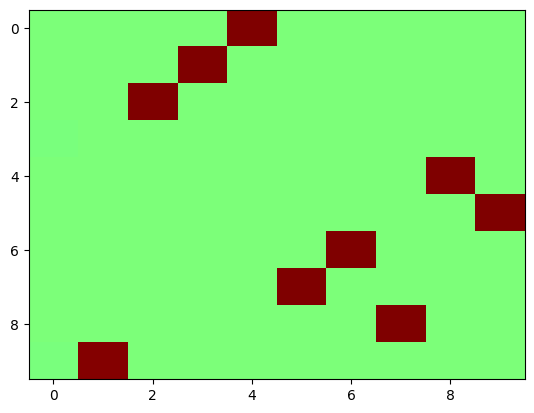

In [184]:
for i in range(0, nIter, 20):
    plt.imshow(allC[:,:,i], vmin=-1, vmax=1, cmap='jet', aspect='auto')
    plt.show()

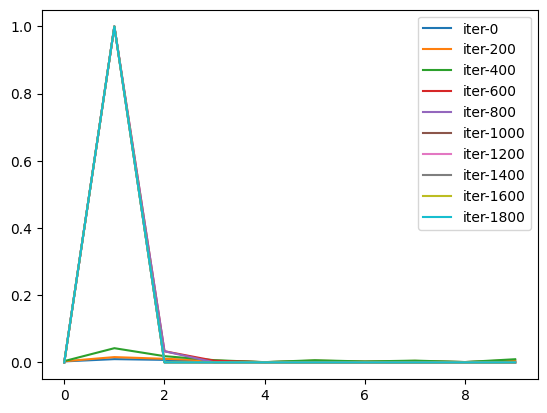

In [198]:
for i in range(0, nIter, 200):
    plt.plot(allC[0,:,i], label=f"iter-{i}")
    
plt.legend()
plt.show()

In [199]:
C.sum(dim=1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor(0.)
tensor(0.)
tensor(0.)


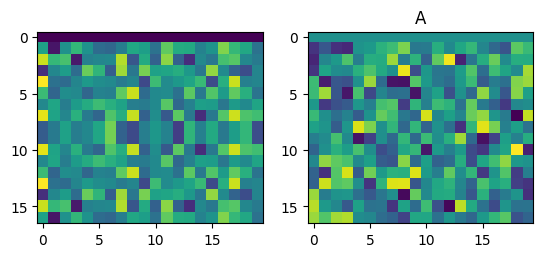

In [304]:
plot_complex(A, "A")

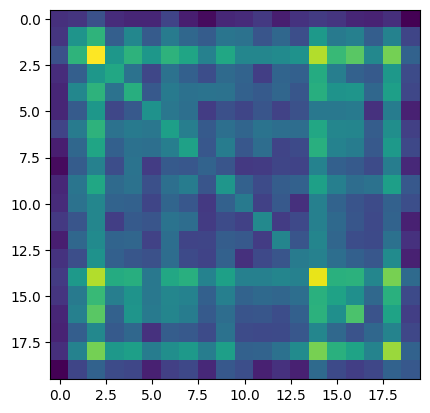

In [334]:
plt.imshow((C.conj().t() @ C).real)

In [289]:
def check_hemi(A):
    A_chop = A[1:,:]
    avg = A_chop + A_chop.flip(dims=[0])
    real_norm = avg.real.norm()
    imag_norm = avg.imag.norm()
    imag_ratio = imag_norm / math.sqrt(real_norm**2 + imag_norm**2)
    print(imag_ratio)

def keep_hemi(A):
    A[1:,:] = (A[1:,:] + A[1:,:].flip(dims=[0]).conj()) / 2
    

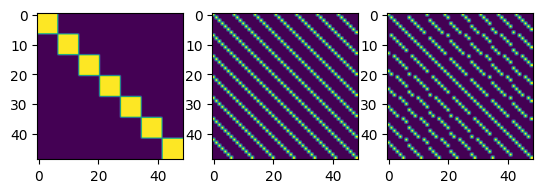

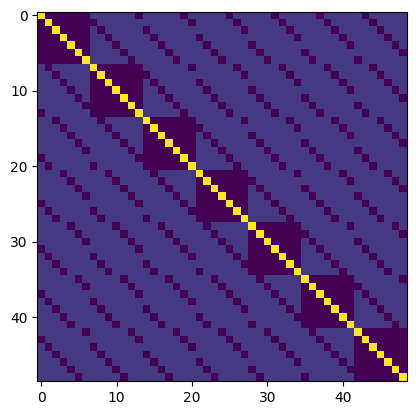

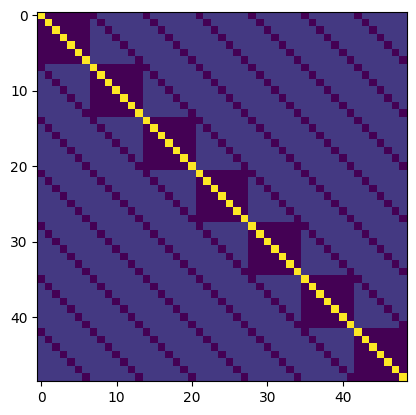

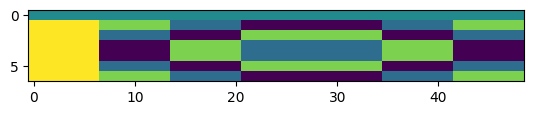

In [483]:
# construct a perfect memorization case.
d = 7
K = d * d

A = torch.zeros(d, K, dtype=torch.cfloat)
B = torch.zeros(d, K, dtype=torch.cfloat)
C = torch.zeros(d, K, dtype=torch.cfloat)

v = torch.ones(d, dtype=torch.cfloat)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)

# construct 
cnt = 0
for i in range(d):
    for j in range(d):
        A[:,cnt] = v[:] ** i
        B[:,cnt] = v[:] ** j
        C[:,cnt] = v[:] ** ((i + j) % d)
        cnt += 1
        
A = A / math.sqrt(d)
B = B / math.sqrt(d)
C = C / 2 / d

noise = 0.0

if noise > 0.0:
    # adding some noise
    A = A + torch.randn(d, K, dtype=torch.cfloat) * noise
    B = B + torch.randn(d, K, dtype=torch.cfloat) * noise
    C = C + torch.randn(d, K, dtype=torch.cfloat) * noise
    
    keep_hemi(A)
    keep_hemi(B)
    keep_hemi(C)

# Getting rid of e_0
remove_e0 = True

if remove_e0:
    A[0,:] = 0
    B[0,:] = 0
    C[0,:] = 0
    
# Check 
AA = A.conj().t() @ A
BB = B.conj().t() @ B
CC = C.conj().t() @ C

plt.subplot(1, 3, 1)
plt.imshow(AA.real)
plt.subplot(1, 3, 2)
plt.imshow(BB.real)
plt.subplot(1, 3, 3)
plt.imshow(CC.real)
plt.show()

plt.imshow((AA * CC).real)
plt.show()

plt.imshow((AA * BB).real)
plt.show()

plt.imshow((A @ (BB * CC)).real)
plt.show()


tensor([[ 1.0000e+00+0.0000e+00j,  4.4331e-09+1.6970e-08j,
          1.2099e-08-4.6526e-11j,  ...,
         -2.0858e-14+1.2540e-15j,  4.1531e-15-8.1966e-16j,
          2.6187e-14+6.5574e-15j],
        [ 4.4331e-09-1.6970e-08j,  1.0000e+00+0.0000e+00j,
          4.5524e-08-1.6399e-08j,  ...,
          1.3471e-14-5.2597e-17j, -1.5738e-14+5.0529e-16j,
          4.3736e-14+5.4082e-15j],
        [ 1.2099e-08+4.6526e-11j,  4.5524e-08+1.6399e-08j,
          1.0000e+00+0.0000e+00j,  ...,
         -1.1113e-14+7.5116e-16j,  9.2828e-15-4.6061e-16j,
         -7.1326e-14-1.0752e-14j],
        ...,
        [-2.0858e-14-1.2540e-15j,  1.3471e-14+5.2597e-17j,
         -1.1113e-14-7.5116e-16j,  ...,
          1.0000e+00+0.0000e+00j,  1.4632e-07+5.9118e-09j,
         -1.3502e-07+6.6264e-09j],
        [ 4.1531e-15+8.1966e-16j, -1.5738e-14-5.0529e-16j,
          9.2828e-15+4.6061e-16j,  ...,
          1.4632e-07-5.9118e-09j,  1.0000e+00+0.0000e+00j,
         -2.0682e-08-4.1850e-09j],
        [ 2.4123e-14+3

In [11]:
1 / (2*d*d)

0.01020408163265306

In [735]:
# check the dynamics
d = 17
# K = d * d
K = 30

noise = 0.1

A = torch.rand(d, K, dtype=torch.cfloat) * noise
B = torch.rand(d, K, dtype=torch.cfloat) * noise
C = torch.rand(d, K, dtype=torch.cfloat) * noise

# make A / B / C symmetric
A[0,:] = 0
B[0,:] = 0
C[0,:] = 0

keep_hemi(A)
keep_hemi(B)
keep_hemi(C)

In [716]:
use_hemi = True

if use_hemi:
    keep_hemi(A)
    keep_hemi(B)
    keep_hemi(C)

    # check_hemi(A)
    # check_hemi(B)
    # check_hemi(C)

nIter = 30000
alpha = 0.02

wd = 0.000

allA = torch.randn(d, K, nIter, dtype=torch.cfloat)
allB = torch.randn(d, K, nIter, dtype=torch.cfloat)
allC = torch.randn(d, K, nIter, dtype=torch.cfloat)

for t in range(nIter):
    allA[:,:,t] = A
    allB[:,:,t] = B
    allC[:,:,t] = C
    
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C
    
    dA = B.conj() * C - 2 * A @ (BB * CC)
    dB = A.conj() * C - 2 * B @ (AA * CC)
    dC = (A*B) - 2 * C @ (AA * BB)
    
    if wd > 0.0:
        dA -= wd * A
        dB -= wd * B
        dC -= wd * C

    if t % 1000 == 0:
        print(t, dA.norm().item(), dB.norm().item(), dC.norm().item())
    
    A = A + alpha * dA
    B = B + alpha * dB
    C = C + alpha * dC
    
    if use_hemi:
        keep_hemi(A)
        keep_hemi(B)
        keep_hemi(C)

# plt.imshow(C)

0 0.06854047626256943 0.0661993995308876 0.0673428326845169
1000 0.30191606283187866 0.30695852637290955 0.30461379885673523
2000 0.047719936817884445 0.046485453844070435 0.04349321871995926
3000 0.0036949971690773964 0.0037107726093381643 0.0035408998373895884
4000 0.0019488624529913068 0.001999706495553255 0.001731158117763698
5000 0.001224493607878685 0.001297037466429174 0.0010361181339249015
6000 0.000854501617141068 0.0009331348701380193 0.0006947724032215774
7000 0.000641249178443104 0.0007172087207436562 0.000500852067489177
8000 0.0005066263838671148 0.0005768490955233574 0.0003797136596404016
9000 0.00041501279338262975 0.0004793383996002376 0.00029894415638409555
10000 0.00034881176543422043 0.0004080144572071731 0.00024232763098552823
11000 0.00029860230279155076 0.00035365676740184426 0.0002010362659348175
12000 0.00025910348631441593 0.00031085306545719504 0.0001698213309282437
13000 0.00022716409876011312 0.0002761783543974161 0.00014564234879799187
14000 0.000200881971

In [739]:
use_hemi = True

if use_hemi:
    keep_hemi(A)
    keep_hemi(B)
    keep_hemi(C)

    # check_hemi(A)
    # check_hemi(B)
    # check_hemi(C)

nIter = 30000
alpha = 0.3

wd = 0.0005

allA = torch.randn(d, K, nIter, dtype=torch.cfloat)
allB = torch.randn(d, K, nIter, dtype=torch.cfloat)
allC = torch.randn(d, K, nIter, dtype=torch.cfloat)

for t in range(nIter):
    allA[:,:,t] = A
    allB[:,:,t] = B
    allC[:,:,t] = C
    
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C
    
    dA = (B * C).conj() - 2 * A @ (BB * CC)
    dB = (A * C).conj() - 2 * B @ (AA * CC)
    dC = (A * B).conj() - 2 * C @ (AA * BB)
    
    if wd > 0.0:
        dA -= wd * A
        dB -= wd * B
        dC -= wd * C

    if t % 1000 == 0:
        print(t, dA.norm().item(), dB.norm().item(), dC.norm().item())
    
    A = A + alpha * dA
    B = B + alpha * dB
    C = C + alpha * dC
    
    if use_hemi:
        keep_hemi(A)
        keep_hemi(B)
        keep_hemi(C)

# plt.imshow(C)

0 8.363139204448089e-05 8.363596862182021e-05 8.947198512032628e-05
1000 8.712817361811176e-05 8.713010902283713e-05 9.186894749291241e-05
2000 8.979933045338839e-05 8.978405094239861e-05 9.34633135329932e-05
3000 9.137592132901773e-05 9.134085848927498e-05 9.405270247953013e-05
4000 9.167973621515557e-05 9.167933603748679e-05 9.358486568089575e-05
5000 9.06838322407566e-05 9.071065142052248e-05 9.195876191370189e-05
6000 8.849609002936631e-05 8.849450387060642e-05 8.930657349992543e-05
7000 8.521392737748101e-05 8.522086864104494e-05 8.571038779336959e-05
8000 8.108023030217737e-05 8.107846224447712e-05 8.13707520137541e-05
9000 7.62788113206625e-05 7.627873128512874e-05 7.645376899745315e-05
10000 7.105331314960495e-05 7.105629629222676e-05 7.114210166037083e-05
11000 6.558526365552098e-05 6.558079621754587e-05 6.56341144349426e-05
12000 6.004190072417259e-05 6.003630915074609e-05 6.006519834045321e-05
13000 5.4566990002058446e-05 5.456508006318472e-05 5.457438237499446e-05
14000 4.9

In [489]:
# simulate the dynamics after the correction

use_hemi = False

if use_hemi:
    keep_hemi(A)
    keep_hemi(B)
    keep_hemi(C)

    # check_hemi(A)
    # check_hemi(B)
    # check_hemi(C)

nIter = 1000
alpha = 0.05

allA = torch.randn(d, K, nIter, dtype=torch.cfloat)
allB = torch.randn(d, K, nIter, dtype=torch.cfloat)
allC = torch.randn(d, K, nIter, dtype=torch.cfloat)

for t in range(nIter):
    allA[:,:,t] = A
    allB[:,:,t] = B
    allC[:,:,t] = C
    
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C
    
    # diagonal elements
    anormsqr = AA.diag()
    bnormsqr = BB.diag() 
    
    # First conv results
    Aconvs = torch.zeros(d, K, K, dtype=torch.cfloat)
    Bconvs = torch.zeros(d, K, K, dtype=torch.cfloat)
    for jj in range(K):
        curr_Aconv = circular_conv(A[:,jj], A[:,jj])
        curr_Bconv = circular_conv(B[:,jj], B[:,jj])
        for j in range(K):
            Aconvs[:,j,jj] = circular_conv(A[:,j], curr_Aconv)
            Bconvs[:,j,jj] = circular_conv(B[:,j], curr_Bconv)
        
    # construct convolutional results
    Aconvs_term = torch.zeros(d, K, dtype=torch.cfloat)
    Bconvs_term = torch.zeros(d, K, dtype=torch.cfloat)
    
    for j in range(K):
        for jj in range(K):
            Aconvs_term[:,j] += Aconvs[:,j,jj] * CC[jj, j]
            Bconvs_term[:,j] += Bconvs[:,j,jj] * CC[jj, j]
            
            
    Aconvs_termC = torch.zeros(K, K, dtype=torch.cfloat)
    Bconvs_termC = torch.zeros(K, K, dtype=torch.cfloat)
    for j in range(K):
        for jj in range(K):
            Aconvs_termC[jj,j] = complex_dot(Aconvs[:,j,jj], A[:,j])
            Bconvs_termC[jj,j] = complex_dot(Bconvs[:,j,jj], B[:,j])

    
    dA = B.conj() * C - A @ (CC @ bnormsqr).diag() - 2 * A @ (BB * CC) - Aconvs_term
    dB = A.conj() * C - B @ (CC @ anormsqr).diag() - 2 * B @ (AA * CC) - Bconvs_term
    dC = (A*B) - C @ (torch.outer(anormsqr, bnormsqr) + torch.outer(bnormsqr, anormsqr) + 4 * AA * BB + Aconvs_termC + Bconvs_termC) / 2
    
    print(dA.norm(), dB.norm(), dC.norm())
    
    import pdb
    pdb.set_trace()
    
    A = A + alpha * dA
    B = B + alpha * dB
    C = C + alpha * dC
    
    print(f"Iter {t}")
    
    if use_hemi:
        keep_hemi(A)
        keep_hemi(B)
        keep_hemi(C)



tensor(6.8073e-07) tensor(6.8358e-07) tensor(8.2393e-06)
> /tmp/ipykernel_3398169/3481469209.py(71)<module>()
     69     pdb.set_trace()
     70 
---> 71     A = A + alpha * dA
     72     B = B + alpha * dB
     73     C = C + alpha * dC

ipdb> exit


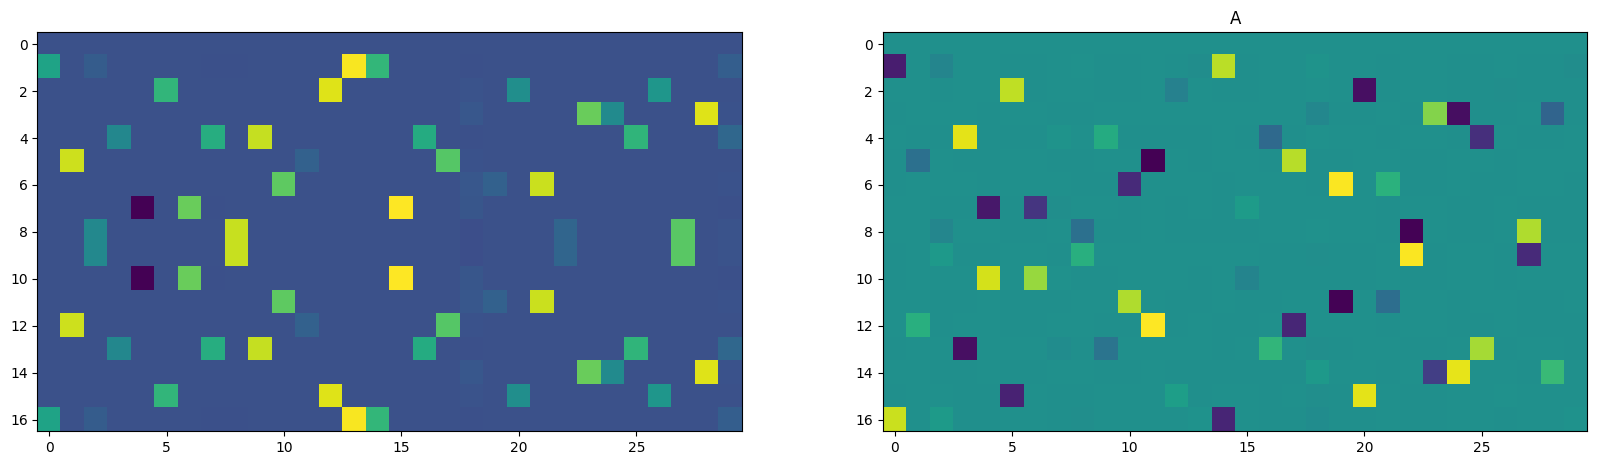

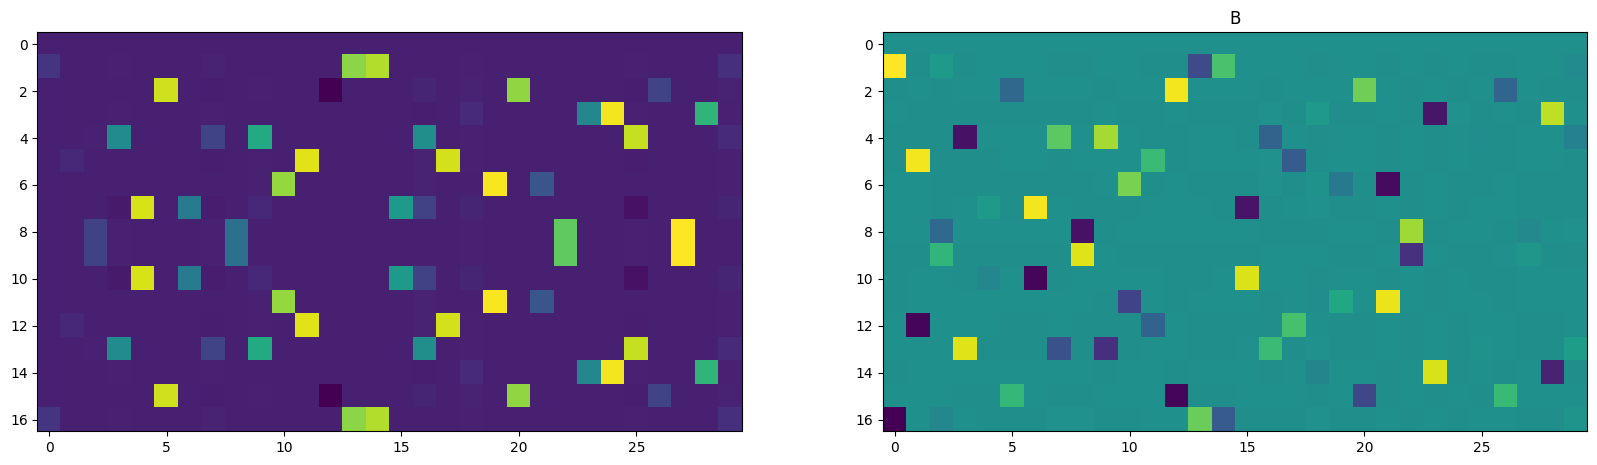

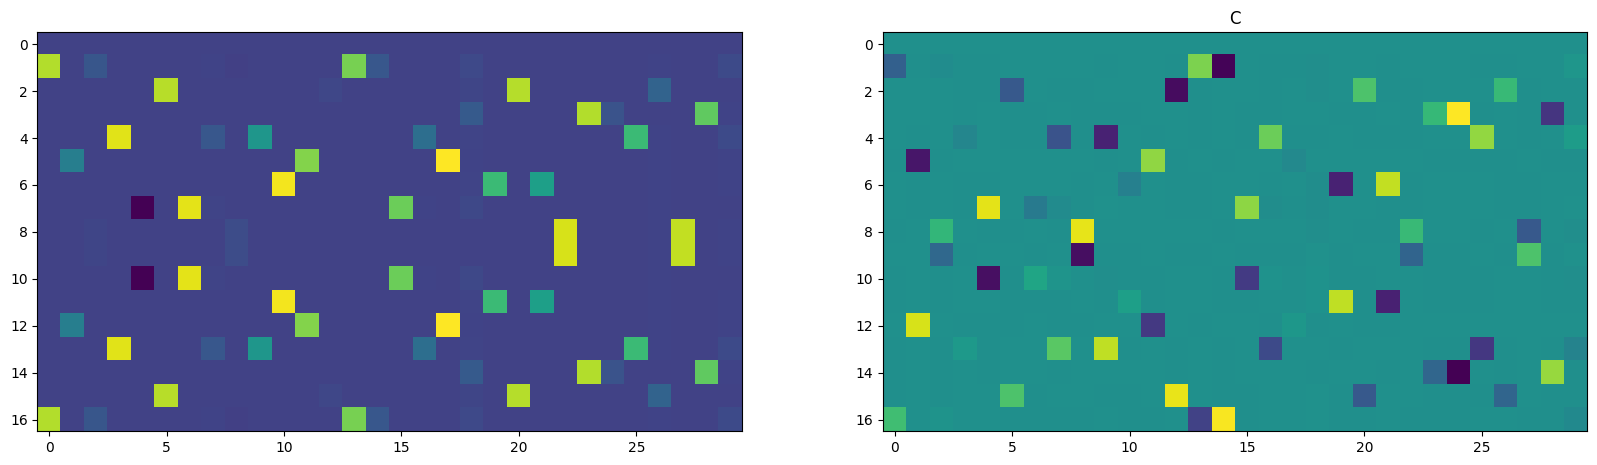

In [865]:
def plot_complex(M, title):
    plt.subplot(1, 2, 1)
    plt.imshow(M.real)
    plt.subplot(1, 2, 2)
    plt.imshow(M.imag)
    plt.title(title)
    plt.show()
    

plt.figure(figsize=(20, 30))
plot_complex(A, "A")
plt.figure(figsize=(20, 30))
plot_complex(B, "B")
plt.figure(figsize=(20, 30))
plot_complex(C, "C")


In [858]:
# Check diagonal and off-diagonal values
diag_values = []
off_diag_values = []

values_a_diag = []
values_a_off_diag = []
values_b_diag = []
values_b_off_diag = []

diag_index = []
off_diag_index = []

for k1 in range(d):
    for k2 in range(d):
        for k3 in range(d):
            v = (A[k1, :] * B[k2, :] * C[k3, :]).sum()
            va = (A[k1, :] * A[k2, :] * C[k3, :]).sum()
            vb = (B[k1, :] * B[k2, :] * B[k3, :]).sum()
            
            if k1 == k2 == k3:
                diag_values.append(v)
                values_a_diag.append(va)
                values_b_diag.append(vb)
            else:
                off_diag_values.append(v)
                values_a_off_diag.append(va)
                values_b_off_diag.append(vb)
                                
diag_values = torch.stack(diag_values)
off_diag_values = torch.stack(off_diag_values)

va_diag_values = torch.stack(values_a_diag)
va_off_diag_values = torch.stack(values_a_off_diag)

vb_diag_values = torch.stack(values_b_diag)
vb_off_diag_values = torch.stack(values_b_off_diag)

print("Off diagonal")
print(off_diag_values.abs().max())
print("diagonal")
print(diag_values)

print(va_off_diag_values.abs().max())
print(va_diag_values)

print(vb_off_diag_values.abs().max())
print(vb_diag_values)


# check second terms
AnormC = (A * A.conj()) @ C.t() 
BnormC = (B * B.conj()) @ C.t() 

print(AnormC.norm(), BnormC.norm())

Off diagonal
tensor(nan)
diagonal
tensor([nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj])
tensor(nan)
tensor([nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj])
tensor(nan)
tensor([nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj])
tensor(nan) tensor(nan)


In [966]:
# let the engine compute gradient descent automatically
d = 7
K = d * d
# K = 30

noise = 0.005

A = torch.rand(d, K, dtype=torch.cfloat) * noise
B = torch.rand(d, K, dtype=torch.cfloat) * noise
C = torch.rand(d, K, dtype=torch.cfloat) * noise

perfect_mem = False

if perfect_mem:
    # Perfect memorization
    v = torch.ones(d, dtype=torch.cfloat)
    # unit 
    for i in range(d):
        v[i].real = math.cos(2 * math.pi * i / d)
        v[i].imag = math.sin(2 * math.pi * i / d)

    # construct 
    cnt = 0
    for i in range(d):
        for j in range(d):
            A[:,cnt] = v[:] ** i
            B[:,cnt] = v[:] ** j
            C[:,cnt] = v[:] ** (- ((i + j) % d))
            cnt += 1

    A = A / math.sqrt(d)
    B = B / math.sqrt(d)
    C = C / d
    
    # add some noise
    if noise > 0.0:
        # adding some noise
        A = A + torch.randn(d, K, dtype=torch.cfloat) * noise
        B = B + torch.randn(d, K, dtype=torch.cfloat) * noise
        C = C + torch.randn(d, K, dtype=torch.cfloat) * noise
    
        keep_hemi(A)
        keep_hemi(B)
        keep_hemi(C)
        
        A = A / 10
        B = B / 10
        C = C / 10

# make A / B / C symmetric
A[0,:] = 0
B[0,:] = 0
C[0,:] = 0

keep_hemi(A)
keep_hemi(B)
keep_hemi(C)
        
A = nn.Parameter(A)
B = nn.Parameter(B)
C = nn.Parameter(C)

# Then we use optimizer to optimize it
# optimizer = optim.Adam([A, B, C], lr=0.05, weight_decay=2e-4)
optimizer = optim.SGD([A, B, C], lr=0.05, weight_decay=5e-4)
nIter = 4000

losses = torch.zeros(nIter, dtype=torch.cfloat)
allA = []
allB = []
allC = []
allts = []

for t in range(nIter):
    optimizer.zero_grad()
    
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C
    
    loss = - 2 * (A * B * C).sum() + (AA * BB * CC).sum() # + AA.diag() @ CC @ BB.diag()
    losses[t] = loss.item()
    loss.backward()
    optimizer.step()
    
    if use_hemi:
        with torch.no_grad():
            keep_hemi(A)
            keep_hemi(B)
            keep_hemi(C)
            
    if t % 100 == 0:
        allA.append(A.detach().clone())
        allB.append(B.detach().clone())
        allC.append(C.detach().clone())
        allts.append(t)


A = A.detach()
B = B.detach()
C = C.detach()


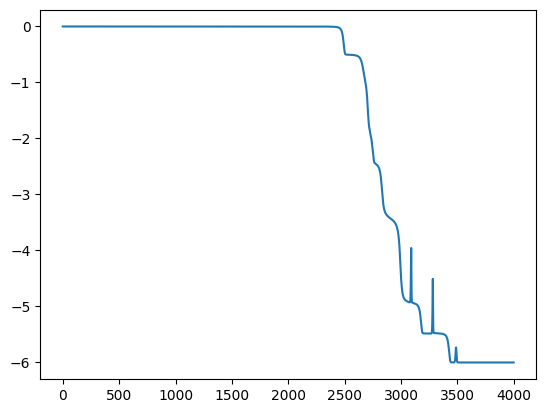

In [967]:
plt.plot(losses.real)

In [970]:
losses.real

tensor([-9.9829e-06, -9.9953e-06, -1.0008e-05,  ..., -6.0000e+00,
        -6.0000e+00, -6.0000e+00])

0 tensor(-9.9829e-06) tensor(0.0497) tensor(0.0524) tensor(0.0496)


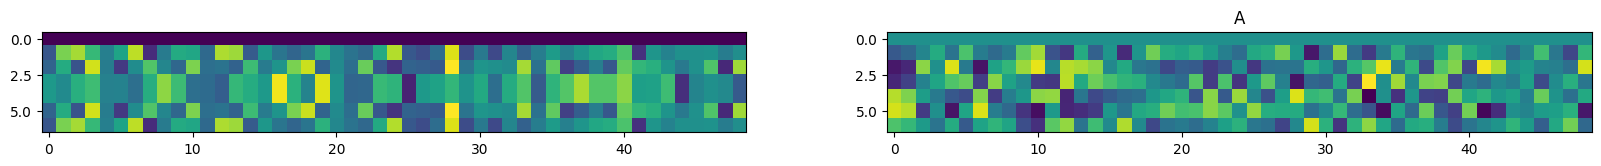

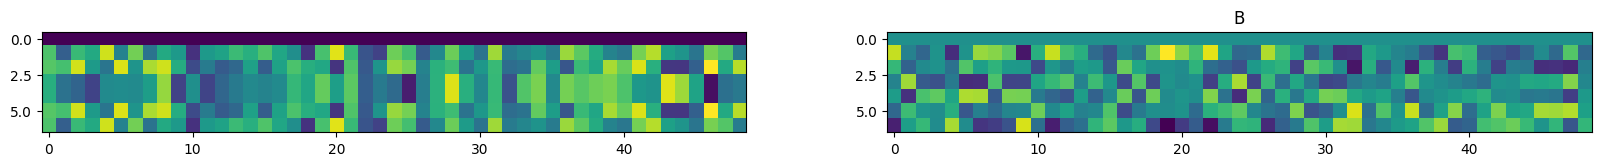

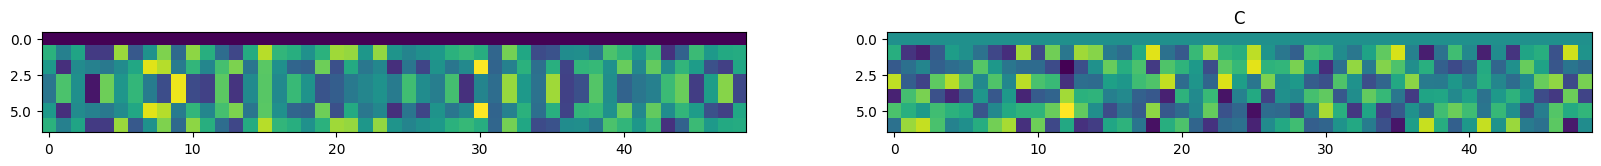

8 tensor(-2.5980e-05) tensor(0.0607) tensor(0.0629) tensor(0.0607)


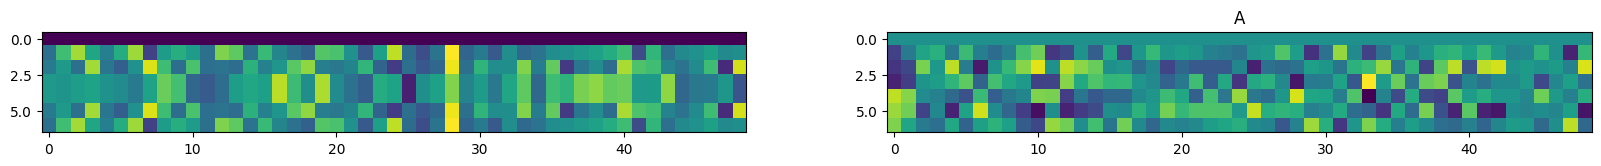

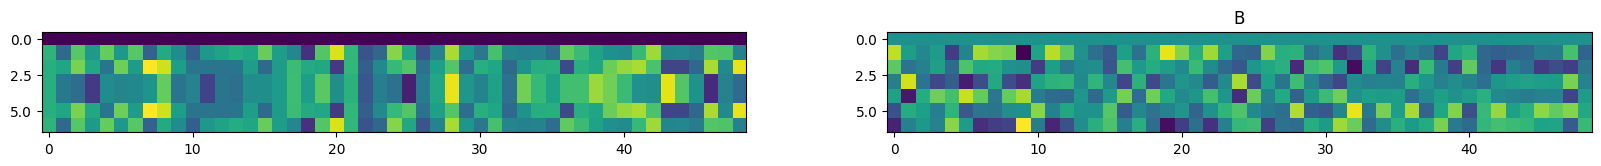

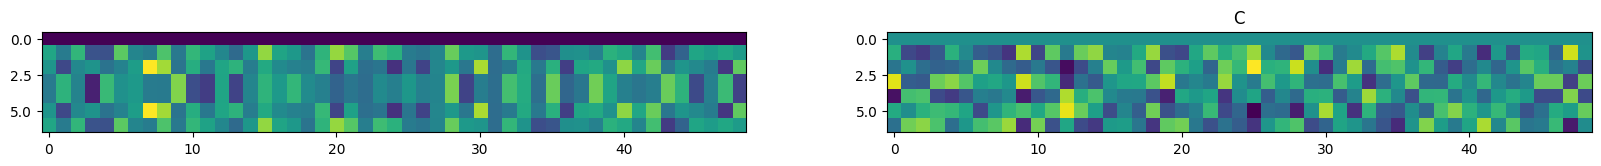

9 tensor(-2.9518e-05) tensor(0.0628) tensor(0.0649) tensor(0.0628)


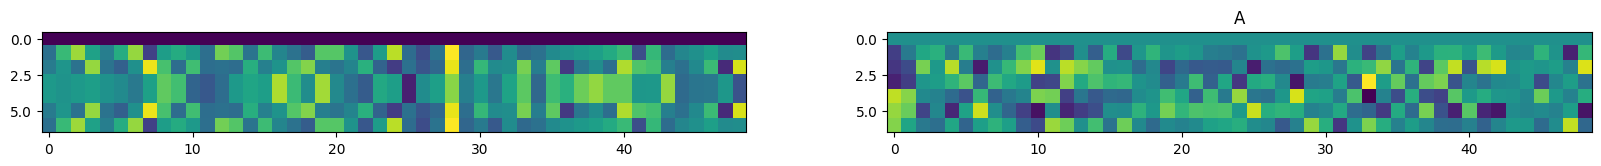

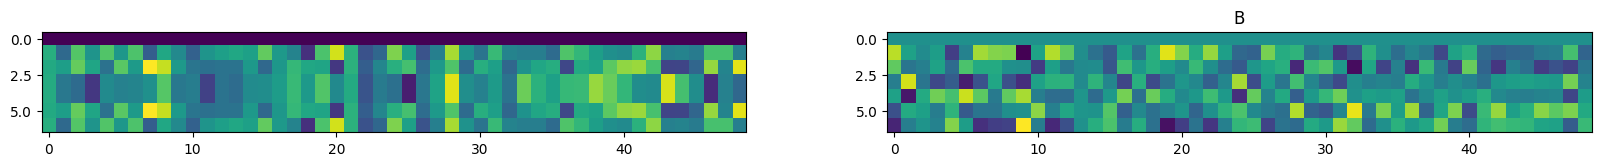

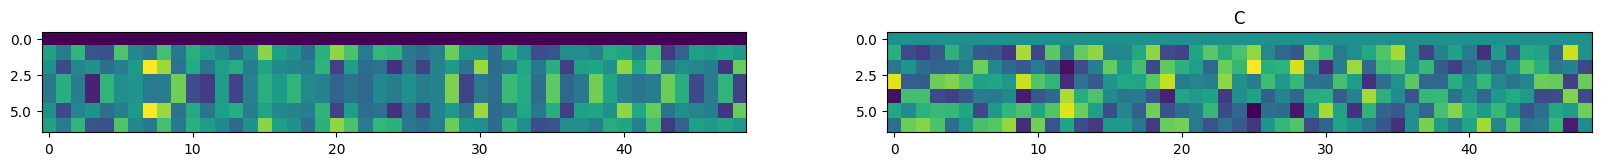

10 tensor(-3.3700e-05) tensor(0.0651) tensor(0.0671) tensor(0.0651)


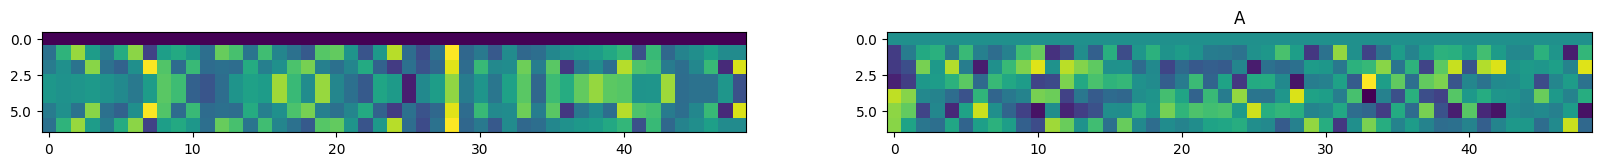

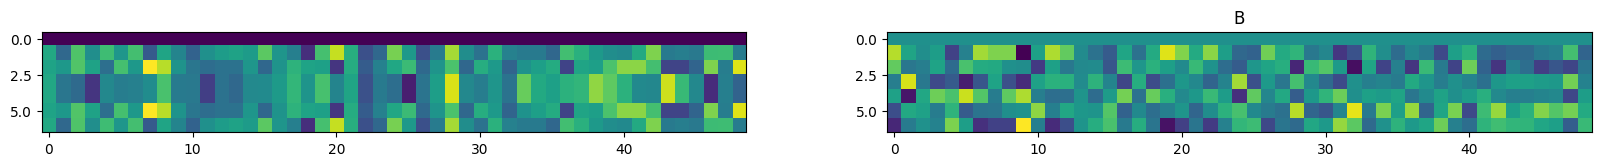

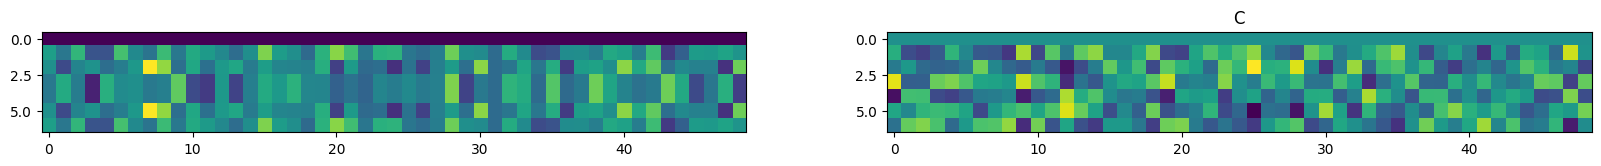

11 tensor(-3.8702e-05) tensor(0.0677) tensor(0.0696) tensor(0.0676)


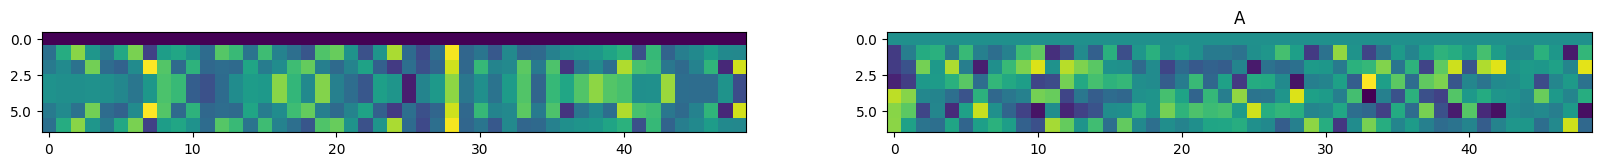

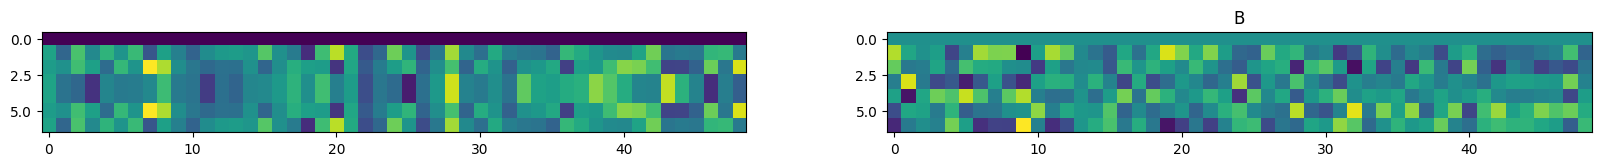

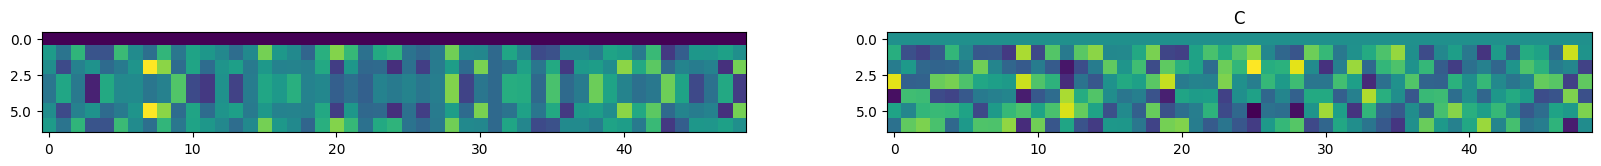

12 tensor(-4.4761e-05) tensor(0.0705) tensor(0.0723) tensor(0.0705)


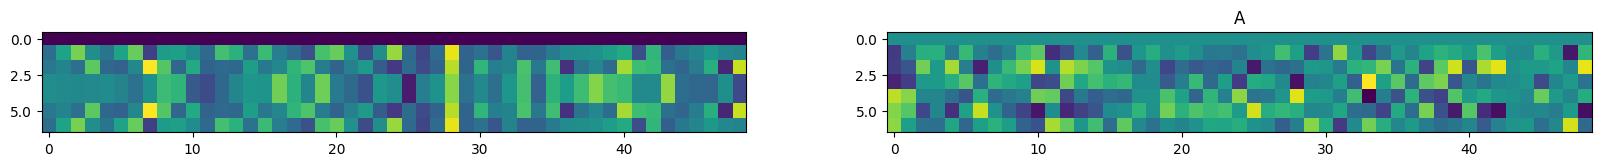

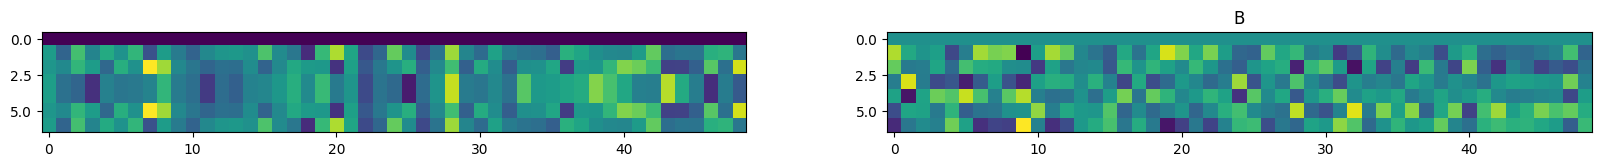

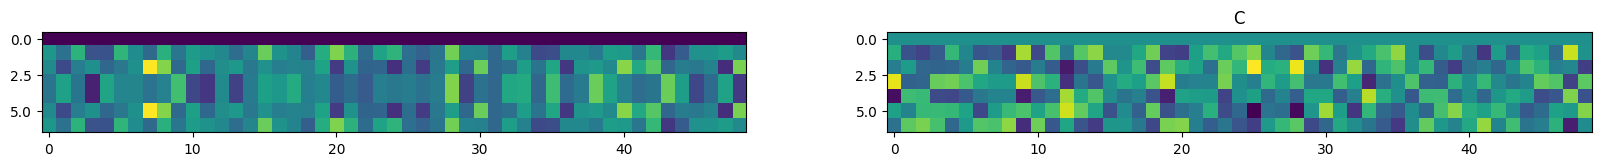

13 tensor(-5.2210e-05) tensor(0.0737) tensor(0.0754) tensor(0.0737)


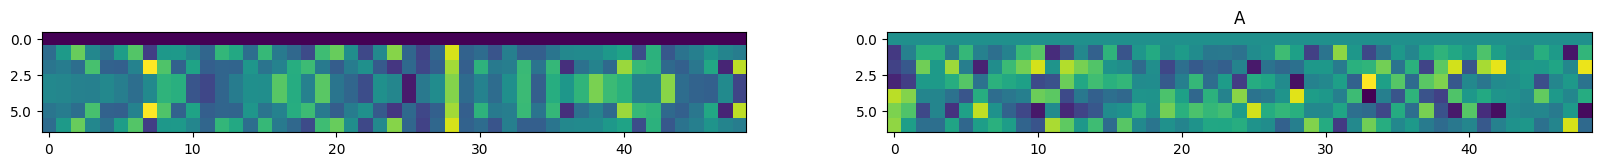

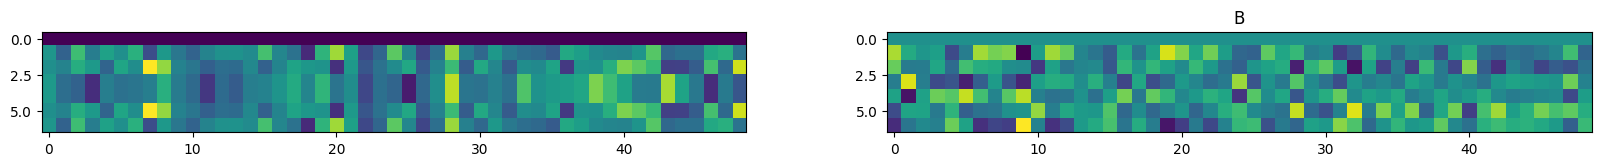

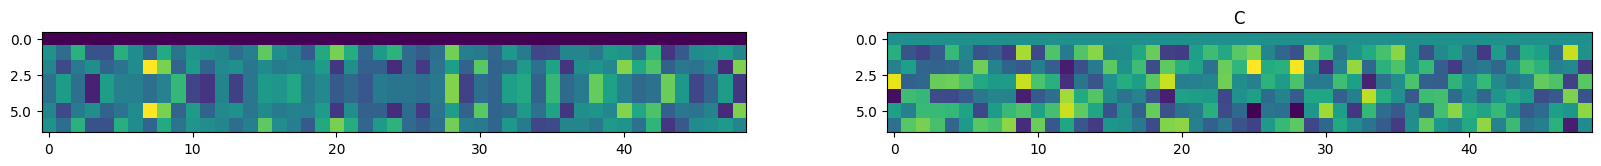

14 tensor(-6.1520e-05) tensor(0.0772) tensor(0.0789) tensor(0.0772)


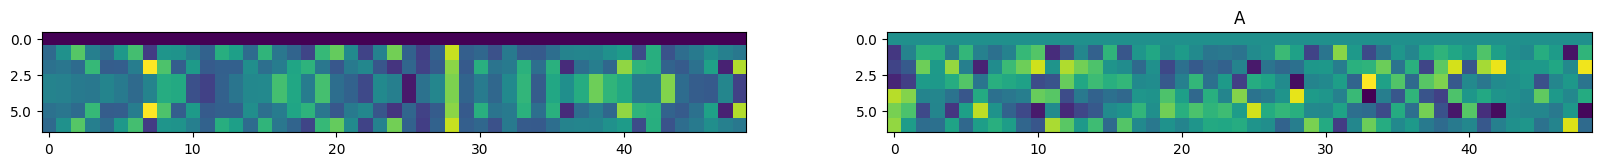

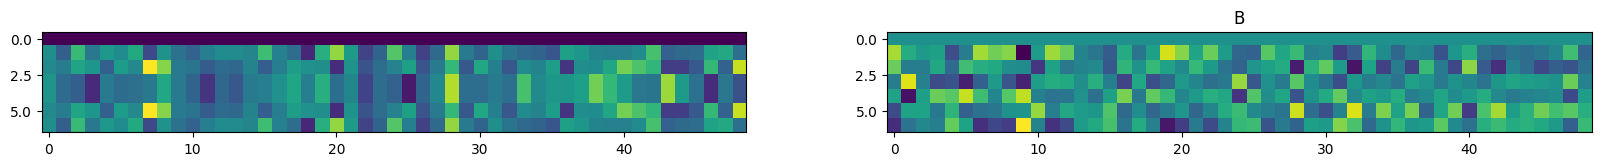

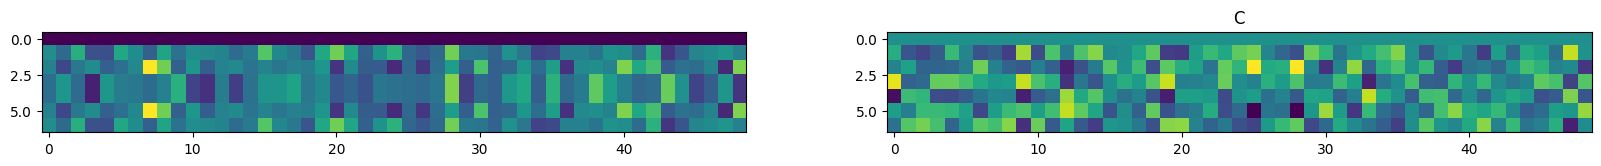

15 tensor(-7.3388e-05) tensor(0.0813) tensor(0.0829) tensor(0.0813)


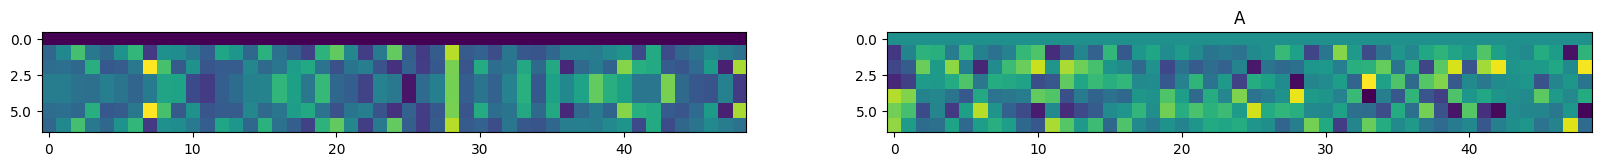

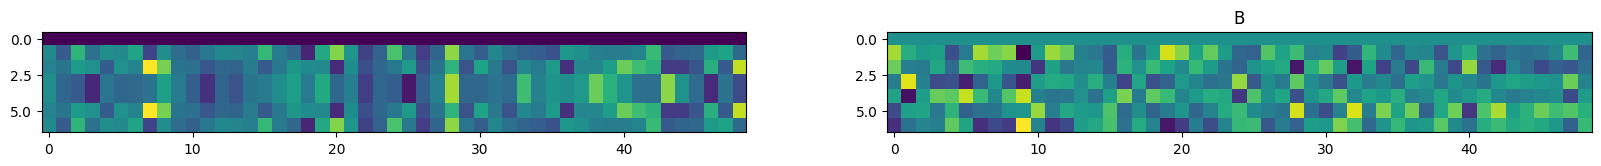

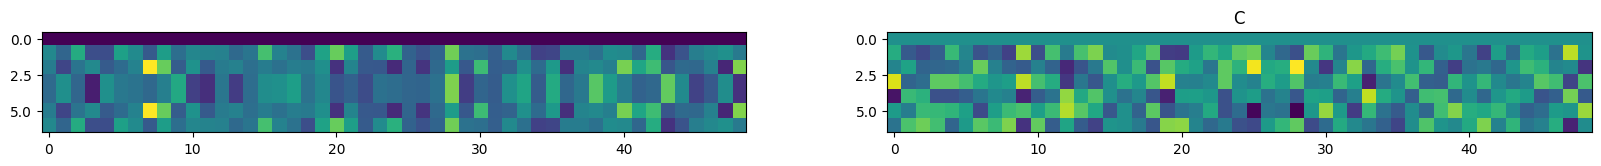

29 tensor(-3.4188) tensor(2.6501) tensor(2.6479) tensor(2.6483)


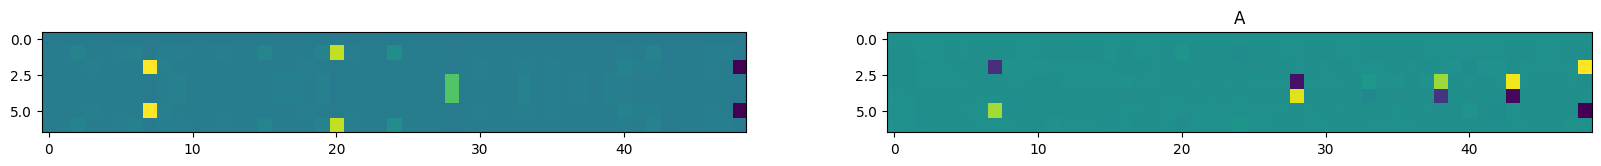

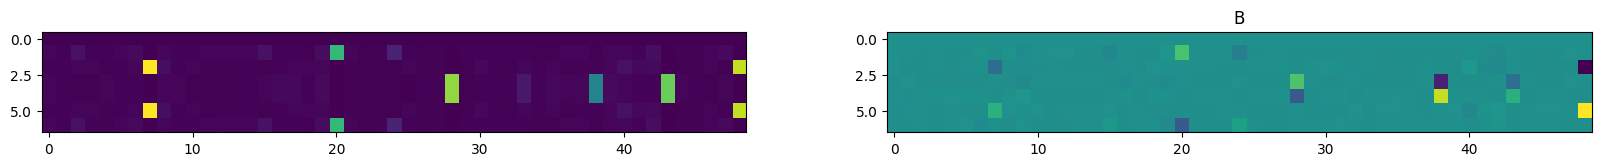

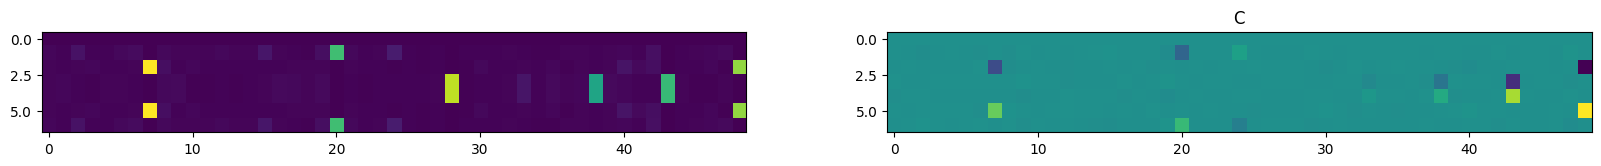

-1 tensor(-6.0000) tensor(3.4673) tensor(3.4656) tensor(3.4678)


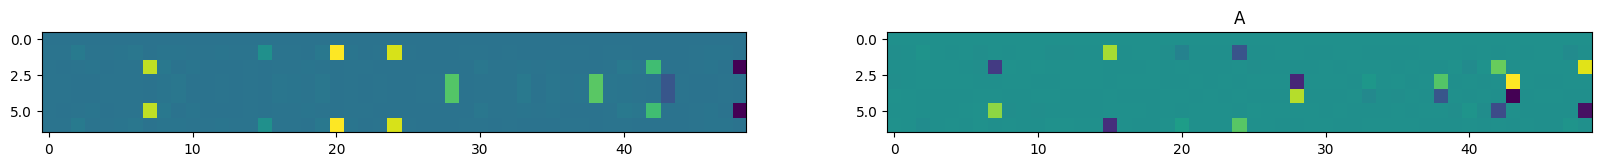

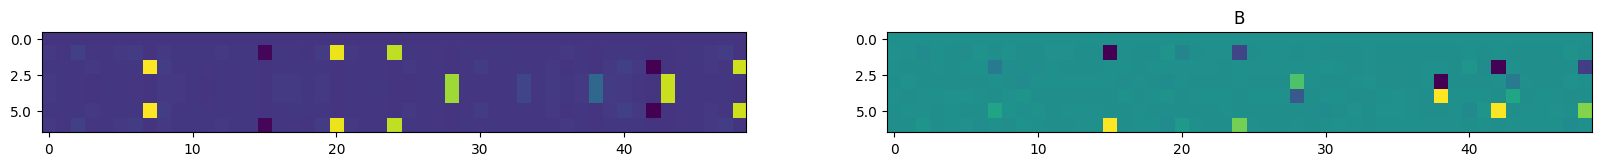

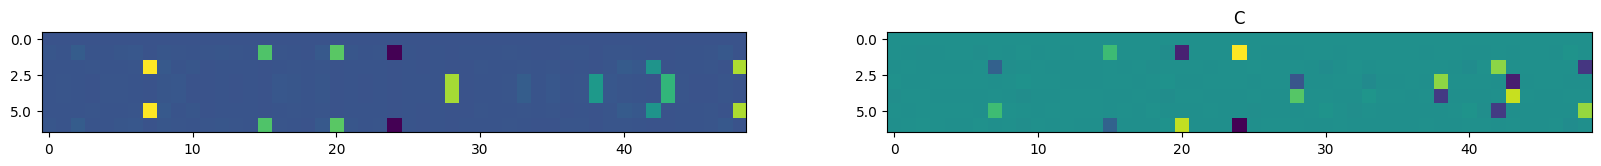

In [969]:
for t in [0, 8, 9, 10, 11, 12, 13, 14, 15, 29, -1]:
    print(t, losses[allts[t]].real, allA[t].norm(), allB[t].norm(), allC[t].norm())
    
    plt.figure(figsize=(20, 30))
    plot_complex(allA[t], "A")
    plt.figure(figsize=(20, 30))
    plot_complex(allB[t], "B")
    plt.figure(figsize=(20, 30))
    plot_complex(allC[t], "C")

In [906]:
allA[2][0,0]

tensor(1.+0.j)

In [792]:
# check how to compute the terms
def get_circular(v):
    n = v.shape[0]
    ret = torch.ones(n, n, dtype=v.dtype)
    for i in range(n):
        for j in range(n):
            ret[i, j] = v[(i - j + n) % n]

    return ret

def circular_conv(*args):
    final = args[0]
    for v in args[1:]:
        final = get_circular(v) @ final
    return final

def complex_dot(v1, v2):
    return (v1.conj() * v2).sum()

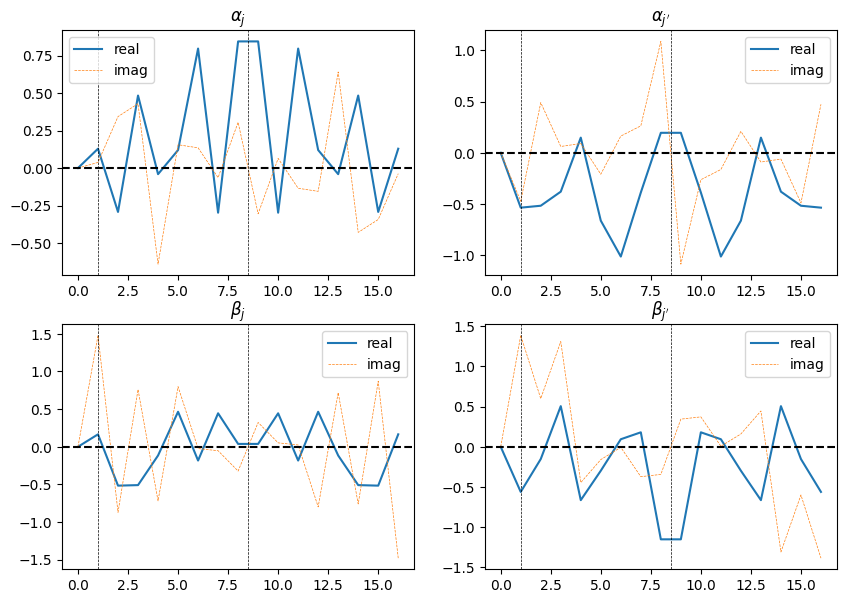

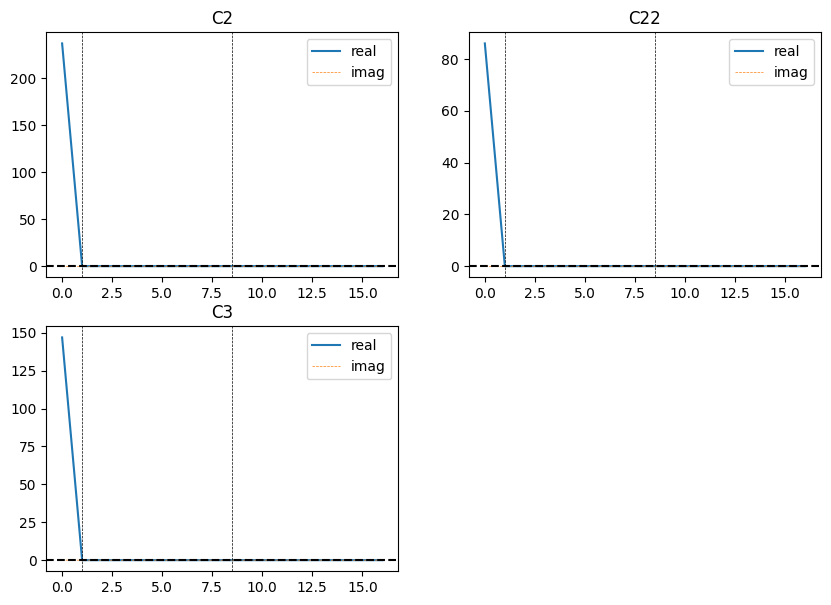

In [523]:
d = 17
# 
omega = torch.ones(d, dtype=torch.cfloat)
# unit 
for i in range(d):
    omega[i].real = math.cos(2 * math.pi * i / d)
    omega[i].imag = math.sin(2 * math.pi * i / d)
    
def init_v(d, hemi=True):
    v = torch.randn(d, dtype=torch.cfloat)
    v[0] = 0
    if hemi:
        v[1:] = (v[1:] + v[1:].flip(dims=[0]).conj()) / 2
    return v

def draw_signal(v, title):
    plt.plot(v.real, label='real')
    plt.plot(v.imag, linestyle="--", linewidth=0.5, label='imag')
    plt.axhline(0, color='k', linestyle='--')
    plt.axvline(1, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(v.shape[0] // 2 + 0.5, color='k', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.title(title)
    
def complex_corr(v1, v2):
    return complex_dot(v1, v2) / v1.norm() / v2.norm()

alpha_j = init_v(d)
alpha_jp = init_v(d)
beta_j = init_v(d)
beta_jp = init_v(d)

k = 7
omegak = omega ** k

C2 = torch.zeros(d, d, dtype=torch.cfloat)
C22 = torch.zeros(d, d, dtype=torch.cfloat)
C3 = torch.zeros(d, d, dtype=torch.cfloat)

C_alpha_jp = get_circular(alpha_jp)
C_alpha_j = get_circular(alpha_j)
    
for i in range(d):
    Cshifted_beta_jp = get_circular(beta_jp * (omegak ** i))
    Cshifted_beta_j = get_circular(beta_j * (omegak ** i))

    #C2 = C2 + C_alpha_j @ Cshifted_beta_jp @ Cshifted_beta_jp
    #C22 = C22 + C_alpha_jp @ Cshifted_beta_jp @ Cshifted_beta_j
    C2 = C2 + Cshifted_beta_jp @ Cshifted_beta_jp
    C22 = C22 + Cshifted_beta_jp @ Cshifted_beta_j

    C3 = C3 + Cshifted_beta_j @ Cshifted_beta_jp @ Cshifted_beta_jp
    
plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)   
draw_signal(alpha_j, r"$\alpha_j$")
plt.subplot(2, 2, 2)   
draw_signal(alpha_jp, r"$\alpha_{j'}$")
plt.subplot(2, 2, 3)   
draw_signal(beta_j, r"$\beta_j$")
plt.subplot(2, 2, 4)   
draw_signal(beta_jp, r"$\beta_{j'}$")
plt.show()

plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1) 
draw_signal(C2[0,:], "C2")
plt.subplot(2, 2, 2) 
draw_signal(C22[0,:], "C22")
plt.subplot(2, 2, 3) 
draw_signal(C3[0,:], "C3")

# check correlation. 
# print("correlation between $\alpha_j.conj$ and C2: ", complex_corr(alpha_j.conj(), C2[0,:]))
# print("correlation between $\alpha_{j'}.conj$ and C22: ", complex_corr(alpha_jp.conj(), C22[0,:]))

# print(torch.dot(f.real, w.real) / f.real.norm() / w.real.norm())

# plt.imshow(V.real)
# plt.show()
# plt.imshow(V.imag)
# plt.show()

In [92]:
C.dtype

torch.float32

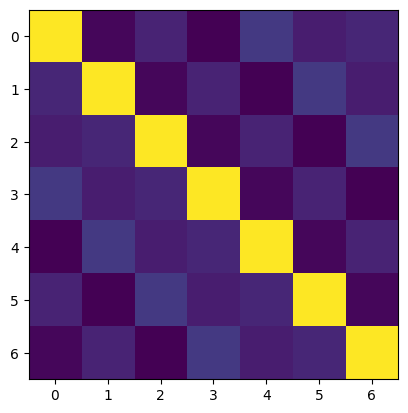

In [51]:
plt.imshow(V.real)

In [53]:
V.real

tensor([[11.1434,  0.2803,  1.1716,  0.0909,  1.9358,  0.9745,  1.2703],
        [ 1.2703, 11.1434,  0.2803,  1.1716,  0.0909,  1.9358,  0.9745],
        [ 0.9745,  1.2703, 11.1434,  0.2803,  1.1716,  0.0909,  1.9358],
        [ 1.9358,  0.9745,  1.2703, 11.1434,  0.2803,  1.1716,  0.0909],
        [ 0.0909,  1.9358,  0.9745,  1.2703, 11.1434,  0.2803,  1.1716],
        [ 1.1716,  0.0909,  1.9358,  0.9745,  1.2703, 11.1434,  0.2803],
        [ 0.2803,  1.1716,  0.0909,  1.9358,  0.9745,  1.2703, 11.1434]])

In [52]:
V.imag

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

all conv:  tensor(0.0333+7.5723e-09j)
estimate:  tensor(0.5384+9.4655e-09j)


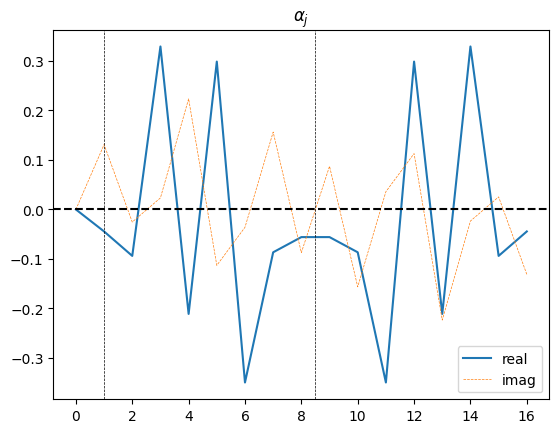

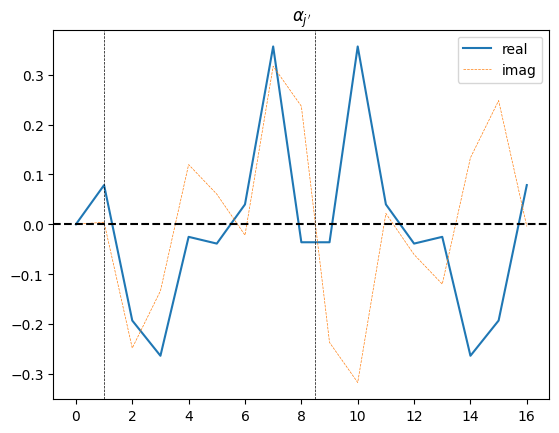

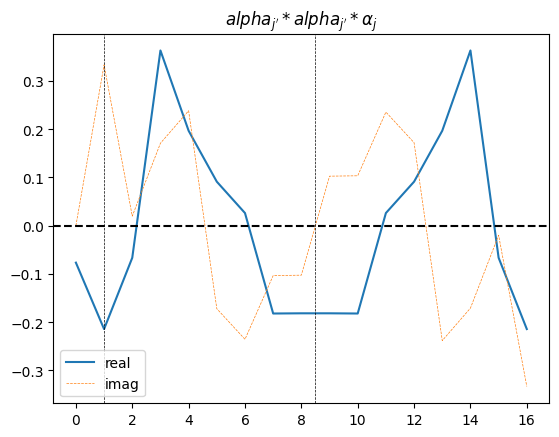

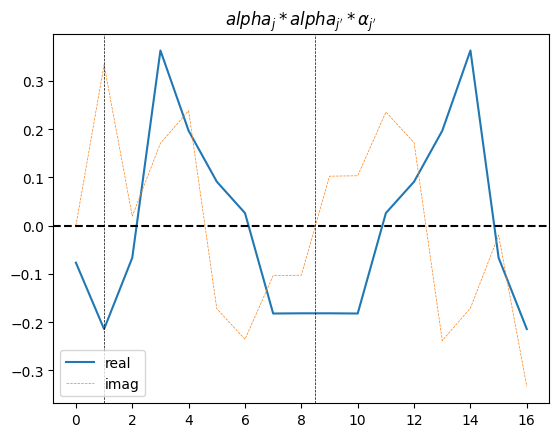

In [111]:
alpha_j = init_v(d)
alpha_jp = init_v(d)

alpha_j = alpha_j / alpha_j.norm()
alpha_jp = alpha_jp / alpha_jp.norm()

C_alpha_jp = get_circular(alpha_jp)
C_alpha_j = get_circular(alpha_j)

# print(complex_corr(C_alpha_jp @ C_alpha_j @ alpha_jp, alpha_j))

print("all conv: ", torch.dot(C_alpha_jp @ C_alpha_jp @ alpha_j, alpha_j))
print("estimate: ", 2*torch.dot(alpha_j, alpha_jp)**2 + torch.dot(alpha_j, alpha_j)**2 + torch.dot(alpha_jp, alpha_jp)**2)

draw_signal(alpha_j, r"$\alpha_j$")
plt.show()
draw_signal(alpha_jp, r"$\alpha_{j'}$")
plt.show()

draw_signal(C_alpha_jp @ C_alpha_jp @ alpha_j, r"$alpha_{j'} * alpha_{j'} * \alpha_j$")
plt.show()
draw_signal(C_alpha_j @ C_alpha_jp @ alpha_jp, r"$alpha_{j} * alpha_{j'} * \alpha_{j'}$")
plt.show()

In [30]:
C_alpha_j @ C_alpha_jp @ C_alpha_jp

tensor([[29.6106-2.2968e-07j, 30.4662+4.1723e-01j, 30.9872-1.7738e-01j,
         30.1453-3.2477e-01j, 29.9603+2.2844e-01j, 30.6973+2.5236e-01j,
         30.4401-3.0370e-01j, 30.0727-8.6230e-02j, 30.4590+4.1802e-04j,
         30.4590-4.1811e-04j, 30.0727+8.6230e-02j, 30.4401+3.0370e-01j,
         30.6973-2.5236e-01j, 29.9603-2.2844e-01j, 30.1453+3.2477e-01j,
         30.9872+1.7738e-01j, 30.4662-4.1723e-01j],
        [30.4662-4.1723e-01j, 29.6106-9.0451e-08j, 30.4662+4.1723e-01j,
         30.9872-1.7738e-01j, 30.1453-3.2477e-01j, 29.9603+2.2844e-01j,
         30.6973+2.5236e-01j, 30.4401-3.0370e-01j, 30.0727-8.6230e-02j,
         30.4590+4.1821e-04j, 30.4590-4.1797e-04j, 30.0727+8.6230e-02j,
         30.4401+3.0370e-01j, 30.6973-2.5236e-01j, 29.9603-2.2844e-01j,
         30.1453+3.2476e-01j, 30.9872+1.7738e-01j],
        [30.9872+1.7738e-01j, 30.4662-4.1723e-01j, 29.6106-4.1636e-08j,
         30.4662+4.1723e-01j, 30.9872-1.7738e-01j, 30.1453-3.2477e-01j,
         29.9603+2.2844e-01j, 30

In [70]:
torch.dot(alpha_j, alpha_j)

tensor(1.3991+1.7703e-08j)

tensor([ 5.5881e+00+1.1921e-07j, -7.1526e-07+2.0862e-06j,
        -5.2452e-06-1.3113e-06j,  3.6955e-06+2.2650e-06j,
         2.9802e-07-3.3975e-06j,  3.6955e-06-1.1921e-07j,
         3.3975e-06+1.1921e-07j])


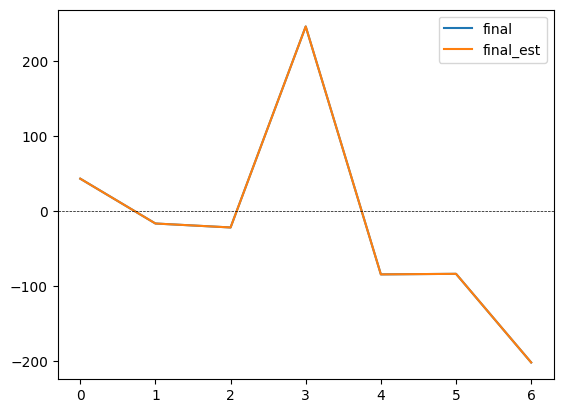

tensor([  43.2868+9.1760e-06j,  -16.4288+9.2478e-07j,  -21.7067-5.7175e-06j,
         246.0700-1.9400e-04j,  -84.2162-4.5934e-05j,  -83.4743+3.6418e-05j,
        -201.5861+1.0564e-04j])
tensor([  43.2868-7.6294e-06j,  -16.4289+1.1444e-05j,  -21.7067+2.6703e-05j,
         246.0701-7.0572e-05j,  -84.2161-7.6294e-06j,  -83.4743+1.5259e-05j,
        -201.5860+2.8610e-05j])
tensor(6.3634e-07)
tensor(5.6192e-07)
tensor(2.4962e-07)


In [522]:
# verify the estimation.
alpha_j = init_v(d)
alpha_jp = init_v(d)
beta_j = init_v(d)
beta_jp = init_v(d)

U = torch.zeros(d, d, dtype=torch.cfloat)
for i in range(d):
    U[:,i] = omega ** i

Ualpha_j = U @ alpha_j 
Ualpha_jp = U @ alpha_jp 
Ubeta_j = U @ beta_j 
Ubeta_jp = U @ beta_jp 

final = torch.zeros(d, dtype=torch.cfloat)

for y1 in range(d):
    for y2 in range(d):
        final[y1] = final[y1] + (Ualpha_j[y1] + Ubeta_j[y2]) * (Ualpha_jp[y1] + Ubeta_jp[y2]) ** 2
        
# final = final / d

yyy = torch.zeros(d, dtype=torch.cfloat)
for y2 in range(d):
    yyy = yyy + circular_conv(beta_jp * U[y2,:], beta_jp * U[y2,:], beta_j * U[y2,:])
    
print(yyy)

# Analytic solution. 
final_est = d * complex_dot(beta_jp, beta_jp) * alpha_j + 2 * d * complex_dot(beta_j, beta_jp) * alpha_jp + d * circular_conv(alpha_jp, alpha_jp, alpha_j) + yyy
Ufinal_est = U @ final_est

plt.plot(final.real, label="final")
plt.plot(Ufinal_est.real, label="final_est")
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

print(final)
print(Ufinal_est)
print((Ufinal_est - final).norm() / final.norm())

est_2 = torch.zeros(d, dtype=torch.cfloat)

for y2 in range(d):
    sigmav_j = alpha_j + beta_j * U[y2,:]
    sigmav_jp = alpha_jp + beta_jp * U[y2,:]
    est_2 = est_2 + circular_conv(sigmav_j, sigmav_jp, sigmav_jp)    

Uest_2 = U @ est_2

print((Uest_2 - final).norm() / final.norm())


print((final_est - est_2).norm() / est_2.norm())

In [520]:
d = 7

omega = torch.ones(d, dtype=torch.cfloat)
# unit 
for i in range(d):
    omega[i].real = math.cos(2 * math.pi * i / d)
    omega[i].imag = math.sin(2 * math.pi * i / d)

# better formulation for the circular convolution
U = torch.zeros(d, d, dtype=torch.cfloat)
for i in range(d):
    U[:,i] = omega ** i
    
hemi = False

K = 10
A = torch.zeros(d, K, dtype=torch.cfloat)
C = torch.zeros(d, K, dtype=torch.cfloat)
for j in range(K):
    A[:,j] = init_v(d, hemi=hemi)
    C[:,j] = init_v(d, hemi=hemi)

result = torch.zeros(d, d, K, dtype=torch.cfloat)
for j in range(K):
    for jp in range(K):
        after_conv = U @ circular_conv(A[:,jp], A[:,jp], A[:,j])
        result[:,:,j] += torch.outer(after_conv, C[:,jp].conj())

# use the formulate to compute
ua = U @ A

result_est = torch.zeros(d, d, K, dtype=torch.cfloat) 
for j in range(K):
    result_est[:,:,j] = ua[:,j].diag() @ (ua * ua) @ C.conj().t()

print((result - result_est).norm() / result.norm())


tensor(4.8399e-07)


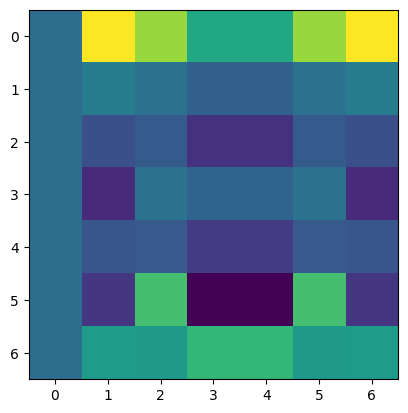

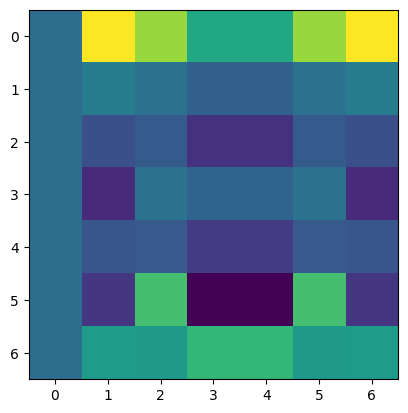

In [508]:
plt.imshow(result[:,:,0].real)
plt.show()
plt.imshow(result_est[:,:,0].real)
plt.show()

In [506]:
ua.imag

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.4506e-09,  0.0000e+00,
         -2.9802e-08,  0.0000e+00, -1.4901e-08,  5.9605e-08,  0.0000e+00],
        [-1.4030e-07,  1.6147e-07, -1.1780e-07,  8.5291e-08,  1.0161e-07,
         -8.0169e-08, -1.0569e-07, -1.5852e-07,  2.3077e-07,  1.5878e-07],
        [-3.8545e-08,  3.3898e-07, -9.5787e-08, -3.8781e-08,  4.4954e-07,
          1.5565e-07, -3.7057e-08,  4.3646e-08,  6.4085e-08,  4.1912e-07],
        [-2.2026e-07, -8.5310e-07,  8.5405e-07, -3.9637e-07,  7.1519e-08,
         -9.4753e-07, -4.6093e-08, -1.3978e-06,  6.7780e-07,  1.0004e-07],
        [ 6.8625e-07, -4.6204e-07, -4.3670e-07, -1.1932e-08, -3.6905e-07,
          5.9280e-07, -1.1237e-07,  1.1947e-06, -8.0126e-07, -6.4196e-07],
        [-1.8173e-07,  2.7546e-07, -3.8886e-07, -4.6924e-08,  3.2478e-07,
         -3.7107e-08, -1.8753e-07, -4.1595e-07,  5.0266e-07,  4.2999e-07],
        [-9.2713e-08,  2.2388e-07, -2.3059e-07, -1.2918e-08,  1.8822e-07,
          9.0933e-08, -1.9425e-0

In [528]:
hemi = True

d = 7

alpha_j = init_v(d, hemi=hemi)
alpha_jp = init_v(d, hemi=hemi)
beta_j = init_v(d, hemi=hemi)
beta_jp = init_v(d, hemi=hemi)

# Third order term. Should just have e_0 component
yyy = torch.zeros(d, dtype=torch.cfloat)
for y2 in range(d):
    yyy = yyy + circular_conv(beta_jp * U[y2,:], beta_jp * U[y2,:], beta_j * U[y2,:])
    
print(yyy)

# First order term. Should be just zero
yyy = torch.zeros(d, dtype=torch.cfloat)
for y2 in range(d):
    yyy = yyy + circular_conv(alpha_jp, alpha_jp, beta_j * U[y2,:])
    
print(yyy)
print(yyy.norm())

yyy = torch.zeros(d, dtype=torch.cfloat)
for y2 in range(d):
    yyy = yyy + circular_conv(alpha_jp, alpha_j, beta_jp * U[y2,:])
    
print(yyy)
print(yyy.norm())

# Second order term.
yyy = torch.zeros(d, dtype=torch.cfloat)
for y2 in range(d):
    yyy = yyy + circular_conv(alpha_j, beta_jp * U[y2,:], beta_jp * U[y2,:])
    # yyy = yyy + circular_conv(beta_jp * U[y2,:], beta_jp * U[y2,:])

yyy_est = d * complex_dot(beta_jp, beta_jp) * alpha_j
# yyy_est = complex_dot(beta_jp, beta_jp)

print((yyy_est - yyy).norm() / yyy.norm())

# Second order term.
yyy = torch.zeros(d, dtype=torch.cfloat)
for y2 in range(d):
    yyy = yyy + circular_conv(alpha_jp, beta_j * U[y2,:], beta_jp * U[y2,:])
    # yyy = yyy + circular_conv(beta_jp * U[y2,:], beta_jp * U[y2,:])

yyy_est = d * complex_dot(beta_j, beta_jp) * alpha_jp
# yyy_est = complex_dot(beta_jp, beta_jp)

print((yyy_est - yyy).norm() / yyy.norm())

tensor([ 1.9949e+01+2.3544e-06j, -7.1526e-07+1.6689e-06j,
        -3.5763e-06+2.3842e-06j, -3.0994e-06+2.1458e-06j,
         1.6689e-06+4.7684e-07j,  2.1458e-06-4.0531e-06j,
        -4.7684e-07-7.1526e-07j])
tensor([ 3.5763e-07-6.6310e-07j,  5.9605e-07+8.9407e-07j,
        -8.9407e-07+5.9605e-07j, -4.1723e-07-9.5367e-07j,
         9.0897e-07+3.5763e-07j, -3.2783e-07+1.4901e-07j,
        -8.8662e-07-3.2783e-07j])
tensor(2.4368e-06)
tensor([ 0.0000e+00-4.4703e-08j,  1.3411e-07-1.1921e-06j,
         4.7684e-07+9.5367e-07j, -2.3842e-07+0.0000e+00j,
        -1.0729e-06+0.0000e+00j,  1.4305e-06-4.1723e-07j,
        -3.5763e-07+7.1526e-07j])
tensor(2.5779e-06)
tensor(2.5134e-07)
tensor(6.8648e-07)


In [526]:
yyy_est

tensor([ -0.0000+0.0000j,  -0.7238-10.5532j, -23.9471-19.0390j,
         28.1287+64.1253j,   8.3247+15.7235j,   8.1235+7.0545j,
         14.4454-9.3989j])

In [527]:
yyy

tensor([-1.4424e-05-1.0014e-05j,  1.4641e+00-1.1615e+01j,
        -2.1946e+01-2.5782e+01j,  1.6874e+01+7.5636e+01j,
         5.6877e+00+1.8850e+01j,  7.3177e+00+9.3931e+00j,
         1.7691e+01-7.1268e+00j])

In [179]:
beta_jp.norm() ** 2

tensor(5.8865)

In [180]:
torch.dot(beta_jp, beta_jp)

tensor(0.6204+5.2516e-08j)

In [181]:
(beta_jp.conj() * beta_jp).sum()

tensor(5.8865-5.1698e-11j)

In [182]:
beta_jp

tensor([ 0.0000+0.0000j,  0.0972+0.0167j,  0.2619-0.5564j,  1.0154+0.1047j,
        -0.1769-0.1815j, -0.0277-0.4848j,  0.3054-0.5245j, -0.4787+0.1648j,
         0.4040-0.6523j,  0.4040+0.6523j, -0.4787-0.1648j,  0.3054+0.5245j,
        -0.0277+0.4848j, -0.1769+0.1815j,  1.0154-0.1047j,  0.2619+0.5564j,
         0.0972-0.0167j])

In [490]:
# Load saved results and check
idx = 900

root = "/private/home/yuandong/luckmatters/ssl/real-dataset"
data = torch.load(os.path.join(root, f"abc{idx}.pth"))

In [327]:
data["allA"].shape

torch.Size([7, 49, 10000])

Iter 1


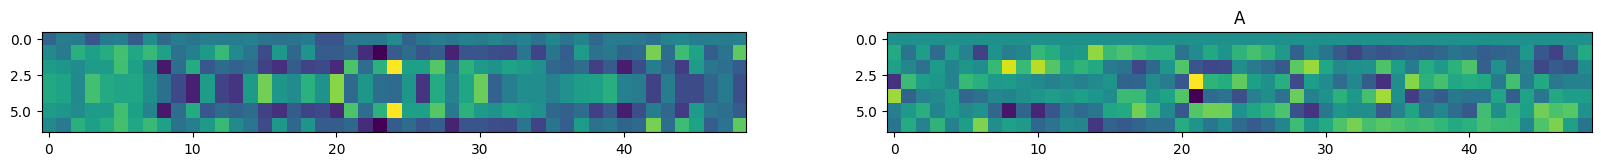

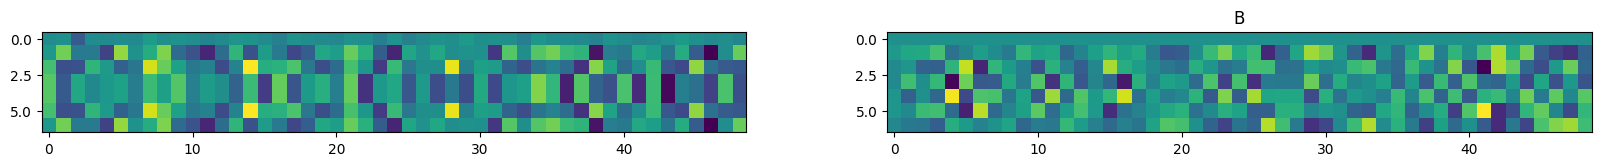

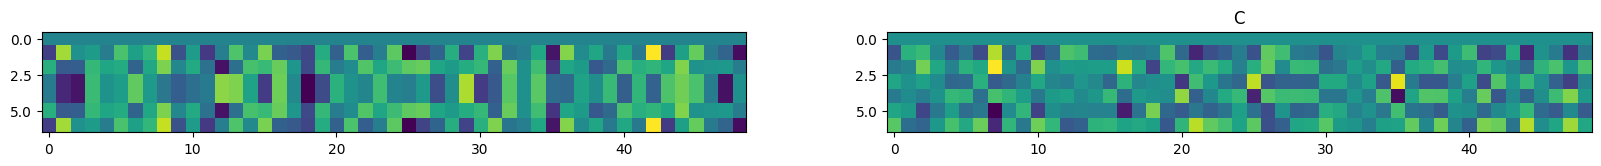

Iter 100


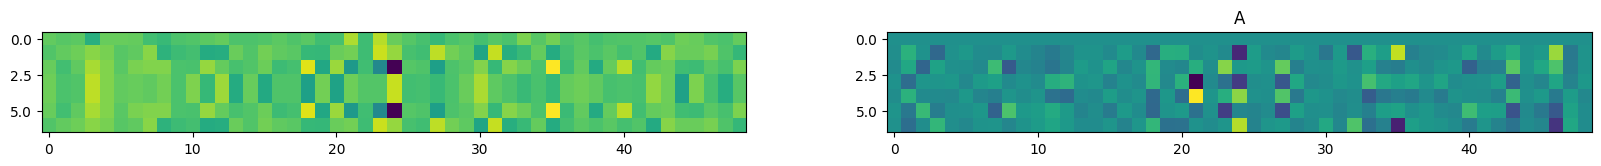

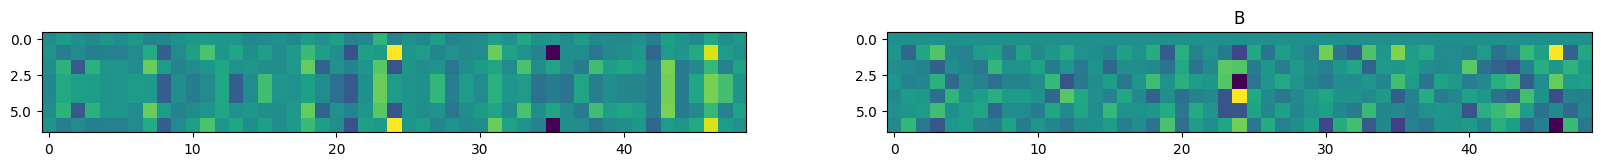

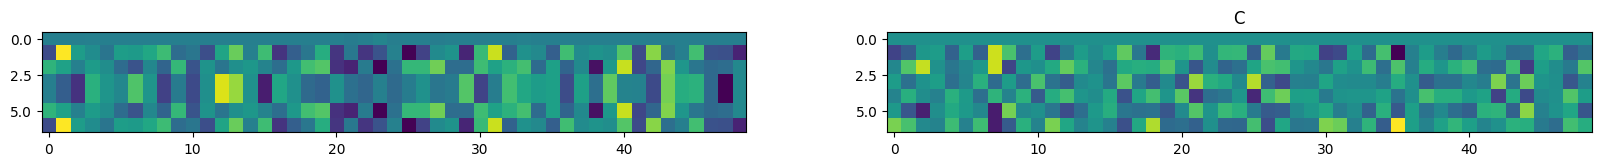

Iter 899


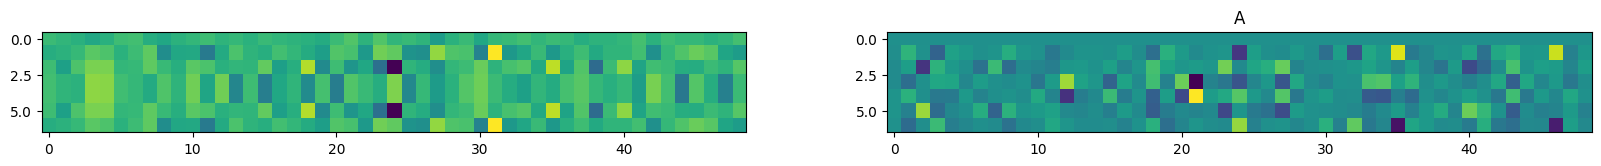

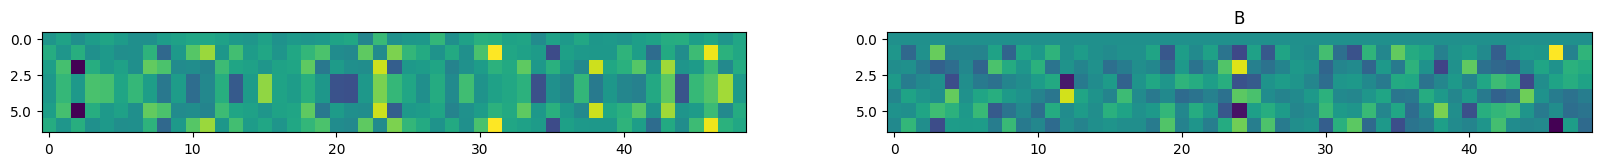

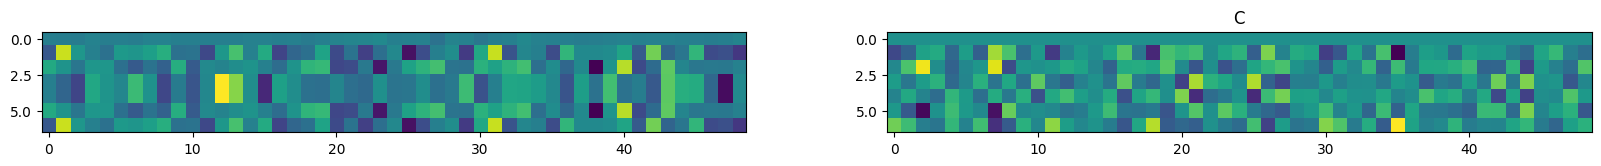

In [491]:
for t in [1, 100, idx-1]:
    print(f"Iter {t}")
    plt.figure(figsize=(20, 30))
    plot_complex(data["allA"][:,:,t], "A")
    plt.figure(figsize=(20, 30))
    plot_complex(data["allB"][:,:,t], "B")
    plt.figure(figsize=(20, 30))
    plot_complex(data["allC"][:,:,t], "C")